This file contains every function that I used to run/train my neural network. In order to avoid a large notebook size, I removed most of the cells that contained calculations, but kept the function definitions.

## preliminary defs


In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, os, json

from classifiers.squeezenet3 import SqueezeNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


##### ref: original squeezenet architechture info

We start with a convolutional neural network pretrained to perform image classification on ImageNet. We will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

Original architecture: 
[numbers in parenthesis tell how many original pixels (along x and y) a neuron "can see"]
<br>input image: 224x224x3 [1]
<br>model.layers[0]
<br>      : 111x111x64 [3] -conv stride2 
<br>m.l[1]: 111x111x64 [3] -relu   **(E)**
<br>m.l[2]: 55x55x64   [7] -maxpool
<br> m.squeezed_layers[0]:
<br>                     55x55x16   [7]
<br>m.l[3]: 55x55x128 [15] -fire
<br> m.sql[1]:           55x55x16  [15] **(D)**
<br>m.l[4]: 55x55x128 [23] -fire
<br>m.l[5]: 27x27x128 [31] -maxpool
<br> m.sql[2]:           27x27x32  [31]
<br>m.l[6]: 27x27x256 [47] -fire
<br> m.sql[3]:           27x27x32  [47] **(C)**
<br>m.l[7]: 27x27x256 [63] -fire
<br>m.l[8]: 13x13x256 [79?] -maxpool
<br> m.sql[4]:           13x13x48  [79?]
<br>m.l[9]: 13x13x384 [111?] -fire
<br> m.sql[5]:           13x13x48  [111?]
<br>m.l[10]:13x13x384 [143?] -fire
<br> m.sql[6]:           13x13x64  [143?]
<br>m.l[11]:13x13x512 [175?] -fire
<br> m.sql[7]:           13x13x64  [175?] **(B)**
<br>m.l[12]:13x13x512 [207?] -fire  = model.features **(A)**
<br>m.l[13]: 13x13x512 -same as [12], saved twice in layers
<br>m.l[14]: 13x13x1000 -conv
<br>m.l[15]: 13x13x1000 -relu
<br>m.l[16]: 1x1x1000   -avgpool
<br>classifier: x1000   -reshape


# Set up training model using pre-computed Features -EXEC

### If necessary, reset tensorflow graph
Note: this will remove from memory any models that have been loaded!!!

In [22]:
tf.reset_default_graph()
sess = get_session()

### functions to read from file

In [19]:
def dataset_XY_from_TFRecord ( layer_name_and_shape_list=[ ("squeezed_layer_8",13,13,64) ],   
                                filename="XandY.tfrec" ):  #, debugN=None ):
    
    Ykeys = ["angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"]
    features1 = { name : tf.FixedLenFeature(shape=[np.prod((W,H,D))], dtype=tf.float32)  \
                for (name,W,H,D) in layer_name_and_shape_list }
    features2 = { k : tf.FixedLenFeature(shape=[1], dtype=tf.float32)  \
                for k in Ykeys }       
    features = { **features1, **features2 } # merge two dicts (python 3)
    #
    dataset = tf.data.TFRecordDataset(filename)
    #
    def input_parser(example_proto):
        # implicitly use features as defined above
        parsed_features = tf.parse_single_example(example_proto, features) 
        result={}
        #reshape:
        for (name,W,H,D) in layer_name_and_shape_list :
            result[name] = tf.reshape(parsed_features[name], (W,H,D))
        result['Y'] = tf.reshape(tf.stack([ parsed_features[name] for name in Ykeys ]),(6,))
        return result
    #
    dataset = dataset.map(input_parser)    
    #
    return dataset


In [20]:
def dataset_XYclassif_from_TFRecord ( layer_name_and_shape_list=[ ("squeezed_layer_8",13,13,64) ],   
                                filename="XandY.tfrec" , includeY=False):  #, debugN=None ):
    
    Ykeys = ["angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"]
    features1 = { name : tf.FixedLenFeature(shape=[np.prod((W,H,D))], dtype=tf.float32)  \
                for (name,W,H,D) in layer_name_and_shape_list }
    features2 = { k : tf.FixedLenFeature(shape=[1], dtype=tf.float32)  \
                for k in Ykeys }       
    features = { **features1, **features2 } # merge two dicts (python 3)
    #
    dataset = tf.data.TFRecordDataset(filename)
    #
    def input_parser(example_proto):
        # implicitly use features as defined above
        parsed_features = tf.parse_single_example(example_proto, features) 
        parsed_features["angle_vert"] = tf.reshape(parsed_features["angle_vert"],[])
        parsed_features["angle_horiz"] = tf.reshape(parsed_features["angle_horiz"],[])
        result={}
        #reshape:
        for (name,W,H,D) in layer_name_and_shape_list :
            result[name] = tf.reshape(parsed_features[name], (W,H,D))
        #angle_vert changes from -0.1 (down) to 0.05(horiz) to 0.2 (up)
        result['class_vert'] = tf.case( { tf.less(  parsed_features["angle_vert"], -0.02): (lambda: tf.constant(0)),
                                          tf.greater(parsed_features["angle_vert"], 0.10): (lambda: tf.constant(1))
                                        }, default = (lambda: tf.constant(2))  
                                        , exclusive=True
                                      )
                                         
        #angle_horiz changes from -0.3 to 0.3
        result['class_horiz'] = tf.case( { tf.less( parsed_features["angle_horiz"], -0.1): (lambda: tf.constant(0)),
                                          tf.greater(parsed_features["angle_horiz"], 0.1): (lambda: tf.constant(1))
                                        }, default = (lambda: tf.constant(2))   
                                        , exclusive=True
                                      )
        if includeY:                                 
            result['Y'] = tf.reshape(tf.stack([ parsed_features[name] for name in Ykeys ]),(6,))
        
        return result
    #
    dataset = dataset.map(input_parser)    
    #
    return dataset


### initialization functions

In [2]:
def initialize_model(var_list, sess):
    ops = [ i.initializer for i in var_list ]
    sess.run(ops)

In [3]:
handles={}

In [4]:
def initialize_training_forfunc_averages_validtn_v2(scopename, func, averages, trainfile, valfile, 
                                                    batch_size=1024,learning_rate=0.003,beta1=0.95, reuse=False, optname="a", 
                                                    validate=False, shuffle_size=None):
    with tf.variable_scope(scopename):
        if shuffle_size is not None:
            y, correct_y, loss, var_list = func(trainfile, averages, batch_size=batch_size, reuse=reuse, 
                                                shuffle_size=shuffle_size )
            if validate:
                val_y, val_correct_y, val_loss, val_var_list = func(valfile, averages, batch_size=batch_size, reuse=True, 
                                                                    shuffle_size=shuffle_size )
        else:
            y, correct_y, loss, var_list = func(trainfile, averages, batch_size=batch_size, reuse=reuse )
            if validate:
                val_y, val_correct_y, val_loss, val_var_list = func(valfile, averages, batch_size=batch_size, reuse=True )
            
        op = tf.train.AdamOptimizer(name=optname,learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        #initialize_model(val_var_list, sess)  # don't need this since the vars are reused
        sess.run(tf.variables_initializer(op.variables()))
    if validate:
        return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [], "val_history":[],
                "fit_history":[], "val_y":val_y, "val_correct_y": val_correct_y, "val_loss": val_loss}
    else:
        return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [],
                "fit_history":[]}

##### older functions:

In [5]:
def initialize_training(scopename, filename, batch_size=2048,learning_rate=0.003,beta1=0.95):
    with tf.variable_scope(scopename):
        y, correct_y, loss, var_list = appended_full_model_v2(filename=filename, batch_size=batch_size, reuse=False )
        op = tf.train.AdamOptimizer(name="a",learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        sess.run(tf.variables_initializer(op.variables()))
    return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [] }


In [6]:
def initialize_training_forfunc_averages(scopename, func, averages, filename, batch_size=1024,learning_rate=0.003,beta1=0.95, reuse=False, optname="a"):
    with tf.variable_scope(scopename):
        y, correct_y, loss, var_list = func(filename, averages, batch_size=batch_size, reuse=reuse )
        op = tf.train.AdamOptimizer(name=optname,learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        sess.run(tf.variables_initializer(op.variables()))
    return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [], "val_history":[], "fit_history":[]}

In [7]:
def initialize_training_forfunc_averages_validtn(scopename, func, averages, trainfile, valfile, batch_size=1024,learning_rate=0.003,beta1=0.95, reuse=False, optname="a", validate=False):
    with tf.variable_scope(scopename):
        y, correct_y, loss, var_list = func(trainfile, averages, batch_size=batch_size, reuse=reuse )
        val_y, val_correct_y, val_loss, val_var_list = func(valfile, averages, batch_size=batch_size, reuse=True )
        op = tf.train.AdamOptimizer(name=optname,learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        initialize_model(val_var_list, sess)
        sess.run(tf.variables_initializer(op.variables()))
    return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [], "val_history":[],
            "fit_history":[], "val_y":val_y, "val_correct_y": val_correct_y, "val_loss": val_loss}

### funcs to calculate normalization

In [8]:
def tftonp(filename, batch_size):
    
    
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    
    dataset = ds.repeat().batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    
    dctn = sess.run(next_element)
    XB,XC,XD = dctn['squeezed_layer_1'],dctn['squeezed_layer_3'],dctn['squeezed_layer_7']
    
    
    averageb,stdb = normalize_num(XB)
    averagec,stdc = normalize_num(XC)
    averaged,stdd = normalize_num(XD)
    return averageb,stdb,averagec,stdc,averaged,stdd

    


In [9]:


def normalize_xb(XB):
    average = np.mean(XB, axis=(0,1,2))
    std = np.std(XB, axis=(0,1,2))
    normXB = (XB-average)/std
    return normXB

def normalize3(XB,XC,XD):
    return normalize_xb(XB),normalize_xb(XC),normalize_xb(XD)

def normalize_num(layer):
    average = np.mean(layer, axis=(0,1,2))
    std = np.std(layer, axis=(0,1,2))
    return average, std

def normalize_total(layer,average,std):
    normlayer = (layer-average)/std
    return normlayer

### Save and restore functions

In [10]:
import pickle

def save_my_model(scope, handles, sess, basedir="./", extra_name=""):
    
    var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=thisscope)
    
    saver = tf.train.Saver(var_list=var_list)
    basename = basedir + '/trained-' + scope +'-' + extra_name + '.ckpt'
    
    saver.save(sess, basename, write_meta_graph=False)
    
    with open( basename + '.handles.pickle', 'wb') as outfile:
        pickle.dump(
            (handles[thisscope]['loss_history'],handles[thisscope]['fit_history'],handles[thisscope]['val_history']),
            outfile)
    print("variables saved:")
    for v in var_list:
        print(v)

In [11]:
def restore_my_model(scope, handles, sess, basedir="./", extra_name="", filename=None):
    ''' if filename is supplied, basedir and extra_name are ignored'''
    var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=thisscope)
    
    saver = tf.train.Saver(var_list=var_list)
    if filename is None:
        filename = basedir + '/trained-' + scope +'-' + extra_name + '.ckpt'
    
    saver.restore(sess, filename)
    
    with open( filename + '.handles.pickle', 'rb') as infile:
        (handles[thisscope]['loss_history'],
         handles[thisscope]['fit_history'],
         handles[thisscope]['val_history']) = pickle.load(infile)

### Plotting function

In [12]:
def plot_loss_and_accuracy(handle_this_scope):

    fig, ax_left = plt.subplots()
    ax_right=ax_left.twinx()

    ax_right.plot(handle_this_scope["loss_history"],'skyblue'); 
    ax_right.set_ylim(min(handle_this_scope["loss_history"]), 
             min(3*max(handle_this_scope["loss_history"][-10:]), max(handle_this_scope["loss_history"]))
            )
    ax_right.set_ylabel("loss", color='skyblue', fontsize=20)
    ax_right.tick_params('y',colors='skyblue', labelsize=14)
    
    ax_left.plot(np.array(handle_this_scope["fit_history"])[:,0], 'r|:')
    ax_left.plot(np.array(handle_this_scope["fit_history"])[:,1], 'g_:');
    ax_left.plot(np.array(handle_this_scope["val_history"])[:,0], 'r|-')
    ax_left.plot(np.array(handle_this_scope["val_history"])[:,1], 'g_-'); 
    ax_left.set_ylim(0,1)
    ax_left.axhline(y=1/3., color='k', linestyle=':',linewidth=0.5)
    ax_left.axhline(y=1/2., color='k', linestyle=':',linewidth=0.5)
    ax_left.axhline(y=2/3., color='k', linestyle=':',linewidth=0.5)
    ax_left.set_ylabel("accuracy\n", color='k', fontsize=20)
    ax_left.tick_params('y',colors='k', labelsize=14)
    
    Ntot=len(handle_this_scope['loss_history'])
    midpoint=(handle_this_scope['loss_history'][0]+handle_this_scope['loss_history'][1])/2
    ax_right.arrow(0.5,midpoint, Ntot/20,0, head_width=0.02, head_length=Ntot/30, fc='skyblue', ec='skyblue')
    #arrow for loss but coordinates in terms of left axis:
    #ax_left.arrow(1,0.9, Ntot/10,0, head_width=0.02, head_length=Ntot/25, fc='b', ec='b')
    plt.show()

# Model versions and training

## V1

In [ ]:

def appended_model_v1(XB, reuse=True):
    '''input: XB - input from layer B of squeezenet
    returns: layers[0...6]'''
    x=XB
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v1', reuse=reuse):
        with tf.variable_scope('layer0'):
            W = tf.get_variable("weights",shape=[1,1,64,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        # fully connected branch:
        #
        with tf.variable_scope('layer2'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 3:
            x = tf.nn.relu(x)
            layers.append(x)
        with tf.variable_scope('layer4'):
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 5:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #fully connected layer:
        with tf.variable_scope('layer6'):
            W = tf.get_variable("weights",shape=[13,13,6,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
    return layers, var_list
                
                
def appended_full_model_v1(filename="XandY1.tfrec", batch_size=2, reuse=True):
    '''dictionary involving both X and Y.
    Expected keys: 
    X: "squeezed_layer_8" (should be obtained by taking layer B (i.e. sq.l.7) of Squeeznet that was fed in the images)
    Y: "angle_vert", "angle_horiz", "rooty", "rootx", "endy", "endx"
     '''
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename=filename )
    dsbatched=ds.repeat().batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v1( nextdict['squeezed_layer_8'], reuse )
    y=tf.reshape(layers[6],[-1,6])
    loss = tf.losses.mean_squared_error( nextdict['Y'], y )
    return y, nextdict['Y'], loss, var_list


def appended_full_model_v1a(filename="XandY1.tfrec", batch_size=2, reuse=True):
    
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename=filename )
    dsbatched=ds.repeat().batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v1( nextdict['squeezed_layer_8'], reuse )
    y=tf.reshape(layers[6],[-1,6])
    
    weights=tf.constant([10.,10,1,1,1,1])
    weighted_loss = tf.losses.mean_squared_error( nextdict['Y']*weights, y*weights )
    
    return y, nextdict['Y'], weighted_loss, var_list


def appended_full_model_v1b(filename="XandY1.tfrec", batch_size=2, reuse=True):
    #no coordinates
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename=filename )
    dsbatched=ds.repeat().batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v1( nextdict['squeezed_layer_8'], reuse )
    y=tf.reshape(layers[6],[-1,6])
    
    weights=tf.constant([10.,10,0,0,0,0])
    weighted_loss = tf.losses.mean_squared_error( nextdict['Y']*weights, y*weights )
    
    return y, nextdict['Y'], weighted_loss, var_list


def appended_full_model_v1c(filename="XandY1.tfrec", batch_size=2, reuse=True):
    #shuffle
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[  ("squeezed_layer_8",13,13,64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v1( nextdict['squeezed_layer_8'], reuse )
    y=tf.reshape(layers[6],[-1,6])
    
    weights=tf.constant([1.,1,0,0,0,0])
    weighted_loss = tf.losses.mean_squared_error( nextdict['Y']*weights, y*weights )
    
    return y, nextdict['Y'], weighted_loss, var_list


## v2: use layers B,C,D [sql7,3,1] - skip

In [7]:

def appended_model_v2(XB,XC,XD, reuse=True):
    '''input: XB,XC, XD - input from layers B,C,D of squeezenet
    returns: layers[0...6]'''
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v2', reuse=reuse):
        x=XD #55x55x16
        with tf.variable_scope('layer0-D'):
            W = tf.get_variable("weights",shape=[1,1,16,10])
            b = tf.get_variable("bias",shape=[10])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 2:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 32x32x10
            
        #this now has the same HW dimension as layer C (which is 27x27x32) :
        x = tf.concat([x,XC], 3)   
        with tf.variable_scope('layer3-C'):
            W = tf.get_variable("weights",shape=[1,1,42,12])
            b = tf.get_variable("bias",shape=[12])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 4:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 5:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x12
        #
        x  = tf.concat([x,XB], 3)   
        with tf.variable_scope('layer6-B'):
            W = tf.get_variable("weights",shape=[1,1,76,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 7:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        with tf.variable_scope('layer8'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 9:
            x = tf.nn.relu(x)
            layers.append(x)
        with tf.variable_scope('layer10'):
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 11:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #fully connected layer:
        with tf.variable_scope('layer12'):
            W = tf.get_variable("weights",shape=[13,13,6,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
    return layers, var_list
                
  

In [8]:
def appended_full_model_v2(filename="XandY1.tfrec", batch_size=2, reuse=True):
    #no coordinates
    ds=dataset_XY_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    layers, var_list = appended_model_v2( nextdict['squeezed_layer_7'], 
                                          nextdict['squeezed_layer_3'],
                                          nextdict['squeezed_layer_1'], reuse )
    y=tf.reshape(layers[12],[-1,6])
    
    weights=tf.constant([10.,10,0,0,0,0])
    weighted_loss = tf.losses.mean_squared_error( nextdict['Y']*weights, y*weights )
    
    return y, nextdict['Y'], weighted_loss, var_list


## normalization  - may need to exec some

#####  calculations - averages 1000

In [23]:
averages_1000 = tftonp('1000_train.tfrec',1000)

## version 4 -skip

In [19]:
def appended_full_model_v4(filename, averages, batch_size=2, reuse=False):
    
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    a1,s1,a3,s3,a7,s7=averages
    layers, var_list = appended_model_v2( ((nextdict['squeezed_layer_7']-a7)/s7), 
                                          ((nextdict['squeezed_layer_3']-a3)/s3),
                                          ((nextdict['squeezed_layer_1']-a1)/s1), reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list

#### train

In [13]:
def initialize_training_forfunc_averages(scopename, func, averages, filename, batch_size=1024,learning_rate=0.003,beta1=0.95, reuse=False, optname="a"):
    with tf.variable_scope(scopename):
        y, correct_y, loss, var_list = func(filename, averages, batch_size=batch_size, reuse=reuse )
        op = tf.train.AdamOptimizer(name=optname,learning_rate=learning_rate,beta1=beta1)
        train_op=op.minimize(loss)
        initialize_model(var_list, sess)
        sess.run(tf.variables_initializer(op.variables()))
    return {"y":y, "correct_y":correct_y, "loss":loss, "train_op":train_op, "loss_history": [], "val_history":[], "fit_history":[]}

##### v4-try1

In [28]:
thisscope="v4-try1"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_xbc4, "XBCDandY_4.tfrec")

###### results

In [29]:
thisscope="v4-try1"
with tf.variable_scope(thisscope):
    for i in range(100):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.2021484375 %, 	 horiz  0.2880859375 %
batch  10	 fit accuracy: vert  0.7802734375 %, 	 horiz  0.4169921875 %
batch  20	 fit accuracy: vert  0.7568359375 %, 	 horiz  0.5009765625 %
batch  30	 fit accuracy: vert  0.8720703125 %, 	 horiz  0.6826171875 %
batch  40	 fit accuracy: vert  0.9990234375 %, 	 horiz  0.892578125 %
batch  50	 fit accuracy: vert  1.0 %, 	 horiz  0.9404296875 %
batch  60	 fit accuracy: vert  1.0 %, 	 horiz  0.9765625 %
batch  70	 fit accuracy: vert  1.0 %, 	 horiz  0.990234375 %
batch  80	 fit accuracy: vert  1.0 %, 	 horiz  0.998046875 %
batch  90	 fit accuracy: vert  1.0 %, 	 horiz  1.0 %


In [30]:

with tf.variable_scope(thisscope):
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                      "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )

	 fit accuracy: vert  1.0 %, 	 horiz  1.0 %


(0, 5)

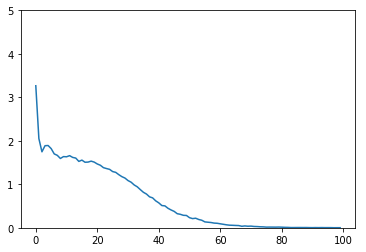

In [31]:
plt.plot(handles[thisscope]["loss_history"][:1000])
plt.ylim(0,5)

##### v4-tr2

In [42]:
thisscope="v4-try4"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_xbc90, "XBCDandY_90.tfrec")

In [44]:
thisscope="v4-try4"
with tf.variable_scope(thisscope):
    for i in range(100):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.2919921875 %, 	 horiz  0.380859375 %
batch  10	 fit accuracy: vert  0.298828125 %, 	 horiz  0.3427734375 %
batch  20	 fit accuracy: vert  0.2744140625 %, 	 horiz  0.345703125 %
batch  30	 fit accuracy: vert  0.4130859375 %, 	 horiz  0.423828125 %
batch  40	 fit accuracy: vert  0.396484375 %, 	 horiz  0.3828125 %
batch  50	 fit accuracy: vert  0.4345703125 %, 	 horiz  0.3740234375 %
batch  60	 fit accuracy: vert  0.427734375 %, 	 horiz  0.404296875 %
batch  70	 fit accuracy: vert  0.513671875 %, 	 horiz  0.35546875 %
batch  80	 fit accuracy: vert  0.7041015625 %, 	 horiz  0.6796875 %
batch  90	 fit accuracy: vert  0.484375 %, 	 horiz  0.4814453125 %


In [45]:

with tf.variable_scope(thisscope):
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                      "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )

	 fit accuracy: vert  0.4697265625 %, 	 horiz  0.591796875 %


(0, 5)

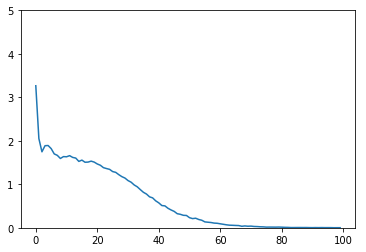

In [31]:
plt.plot(handles[thisscope]["loss_history"][:1000])
plt.ylim(0,5)

##### v4-try4long

In [15]:
thisscope="v4-try4long"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_xbc90, "XBCDandY_90.tfrec", optname="a")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [16]:
thisscope="v4-try4long"
with tf.variable_scope(thisscope):
    for i in range(1000):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3994140625 %, 	 horiz  0.34375 %
batch  10	 fit accuracy: vert  0.2373046875 %, 	 horiz  0.3115234375 %
batch  20	 fit accuracy: vert  0.2490234375 %, 	 horiz  0.296875 %
batch  30	 fit accuracy: vert  0.392578125 %, 	 horiz  0.4052734375 %
batch  40	 fit accuracy: vert  0.349609375 %, 	 horiz  0.36328125 %
batch  50	 fit accuracy: vert  0.4013671875 %, 	 horiz  0.3984375 %
batch  60	 fit accuracy: vert  0.4716796875 %, 	 horiz  0.4423828125 %
batch  70	 fit accuracy: vert  0.3251953125 %, 	 horiz  0.376953125 %
batch  80	 fit accuracy: vert  0.580078125 %, 	 horiz  0.5556640625 %
batch  90	 fit accuracy: vert  0.611328125 %, 	 horiz  0.3916015625 %
batch  100	 fit accuracy: vert  0.580078125 %, 	 horiz  0.6064453125 %
batch  110	 fit accuracy: vert  0.49609375 %, 	 horiz  0.462890625 %
batch  120	 fit accuracy: vert  0.63671875 %, 	 horiz  0.5322265625 %
batch  130	 fit accuracy: vert  0.4482421875 %, 	 horiz  0.4287109375 %
batch  140	 fit accuracy: ve

In [17]:

with tf.variable_scope(thisscope):
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                      "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )

	 fit accuracy: vert  0.84765625 %, 	 horiz  0.8544921875 %


(0, 5)

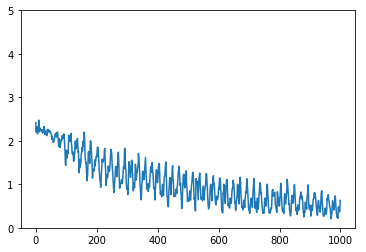

In [18]:
plt.plot(handles[thisscope]["loss_history"][:1000])
plt.ylim(0,5)

### w/ validation 

#### before "exec v4a"-skip

###### functions

In [33]:
def valacc(thisscope, filename, averages, batch):
    with tf.variable_scope(thisscope):
        y , ycor, _, _ = appended_full_model_v4(filename, averages, batch_size=batch, reuse=True)
        
        y_num, ycor_num = sess.run ([y,ycor])
        a,b = np.mean( np.argmax(y_num[0],axis=1) == ycor_num[0] )*100, np.mean( np.argmax(y_num[1],axis=1) == ycor_num[1] )*100 
        print ("\t validation accuracy: vert ",a,  "%, \t horiz ", b,"%" )
        return a,b

In [22]:

def load_train_and_val (train=1, valid=1, test=1, path=__file__, filename="default"):
    generate_XFeat_and_Y_TFRecord(  in_list[:train], my_Xraw[:train], my_Xref[:train],  model, [], [1,3,7], filename=filename+"_train" )
    generate_XFeat_and_Y_TFRecord(  in_list[test:valid], my_Xraw[valid], my_Xref[valid],  model, [], [1,3,7], filename=filename+"_valid" )
    generate_XFeat_and_Y_TFRecord(  in_list[test], my_Xraw[test], my_Xref[test],  model, [], [1,3,7], filename=filename+"_test" )
    

NameError: name '__file__' is not defined

##### trys

###### v4-tryvalid

In [25]:
thisscope="v4-1tryvalid"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_150, "simple150_train.tfrec", optname="b")

In [26]:
thisscope="v4-1tryvalid"
with tf.variable_scope(thisscope):
    for i in range(1000):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3037109375 %, 	 horiz  0.30859375 %
batch  10	 fit accuracy: vert  0.3017578125 %, 	 horiz  0.3271484375 %
batch  20	 fit accuracy: vert  0.3701171875 %, 	 horiz  0.30859375 %
batch  30	 fit accuracy: vert  0.3798828125 %, 	 horiz  0.4189453125 %
batch  40	 fit accuracy: vert  0.5400390625 %, 	 horiz  0.4130859375 %
batch  50	 fit accuracy: vert  0.455078125 %, 	 horiz  0.4912109375 %
batch  60	 fit accuracy: vert  0.390625 %, 	 horiz  0.4033203125 %
batch  70	 fit accuracy: vert  0.3603515625 %, 	 horiz  0.373046875 %
batch  80	 fit accuracy: vert  0.650390625 %, 	 horiz  0.578125 %
batch  90	 fit accuracy: vert  0.5615234375 %, 	 horiz  0.423828125 %
batch  100	 fit accuracy: vert  0.3486328125 %, 	 horiz  0.52734375 %
batch  110	 fit accuracy: vert  0.3837890625 %, 	 horiz  0.5791015625 %
batch  120	 fit accuracy: vert  0.7431640625 %, 	 horiz  0.642578125 %
batch  130	 fit accuracy: vert  0.609375 %, 	 horiz  0.4921875 %
batch  140	 fit accuracy: ver

In [37]:
for i in range(5):
    valacc(thisscope, "simple150_valid.tfrec", averages_150, 2000)

	 validation accuracy: vert  0.519 %, 	 horiz  0.467 %
	 validation accuracy: vert  0.512 %, 	 horiz  0.475 %
	 validation accuracy: vert  0.516 %, 	 horiz  0.477 %
	 validation accuracy: vert  0.523 %, 	 horiz  0.493 %
	 validation accuracy: vert  0.5115 %, 	 horiz  0.489 %


###### try-5

In [28]:
thisscope="v4-cmpltnrm"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_norm160, "stable160_train.tfrec", optname="a")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [29]:
thisscope="v4-cmpltnrm"
with tf.variable_scope(thisscope):
    for i in range(1):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.326171875 %, 	 horiz  0.3798828125 %
batch  10	 fit accuracy: vert  0.416015625 %, 	 horiz  0.3603515625 %
batch  20	 fit accuracy: vert  0.546875 %, 	 horiz  0.4892578125 %
batch  30	 fit accuracy: vert  0.6279296875 %, 	 horiz  0.599609375 %
batch  40	 fit accuracy: vert  0.7119140625 %, 	 horiz  0.6572265625 %
batch  50	 fit accuracy: vert  0.7744140625 %, 	 horiz  0.708984375 %
batch  60	 fit accuracy: vert  0.82421875 %, 	 horiz  0.7822265625 %
batch  70	 fit accuracy: vert  0.8828125 %, 	 horiz  0.8515625 %
batch  80	 fit accuracy: vert  0.9140625 %, 	 horiz  0.890625 %
batch  90	 fit accuracy: vert  0.94921875 %, 	 horiz  0.9384765625 %
batch  100	 fit accuracy: vert  0.962890625 %, 	 horiz  0.9638671875 %
batch  110	 fit accuracy: vert  0.984375 %, 	 horiz  0.9873046875 %
batch  120	 fit accuracy: vert  0.9892578125 %, 	 horiz  0.9912109375 %
batch  130	 fit accuracy: vert  0.99609375 %, 	 horiz  0.9970703125 %
batch  140	 fit accuracy: vert  0.9

KeyboardInterrupt: 

(0, 0.05)

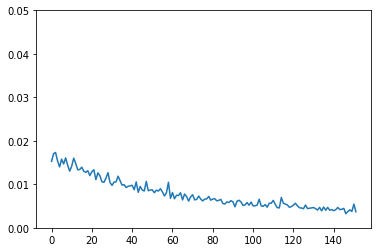

In [39]:
plt.plot(handles[thisscope]["loss_history"][200:1000])
plt.ylim(0,.05)

In [34]:
valacc(thisscope, "stable160_test.tfrec", averages_norm160, 2000)

	 validation accuracy: vert  50.1 %, 	 horiz  45.95 %


###### v4-noflip

In [43]:
thisscope="v4-noflip1"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_nf160, "noflip160_train.tfrec", optname="a")

In [44]:
thisscope="v4-noflip1"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000)
            print ("\t fit accuracy: vert ", np.mean( np.argmax(y[0],axis=1) == cor_y[0] ), 
                          "%, \t horiz ", np.mean( np.argmax(y[1],axis=1) == cor_y[1] ), "%" )
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.33984375 %, 	 horiz  0.3896484375 %
batch  10	 fit accuracy: vert  0.3662109375 %, 	 horiz  0.3447265625 %
batch  20	 fit accuracy: vert  0.3671875 %, 	 horiz  0.39453125 %
batch  30	 fit accuracy: vert  0.4404296875 %, 	 horiz  0.4873046875 %
batch  40	 fit accuracy: vert  0.5478515625 %, 	 horiz  0.5224609375 %
batch  50	 fit accuracy: vert  0.6181640625 %, 	 horiz  0.5966796875 %
batch  60	 fit accuracy: vert  0.6982421875 %, 	 horiz  0.6396484375 %
batch  70	 fit accuracy: vert  0.73828125 %, 	 horiz  0.7060546875 %
batch  80	 fit accuracy: vert  0.7890625 %, 	 horiz  0.75 %
batch  90	 fit accuracy: vert  0.82421875 %, 	 horiz  0.8056640625 %
batch  100	 fit accuracy: vert  0.8408203125 %, 	 horiz  0.8427734375 %
batch  110	 fit accuracy: vert  0.8935546875 %, 	 horiz  0.8984375 %
batch  120	 fit accuracy: vert  0.912109375 %, 	 horiz  0.904296875 %
batch  130	 fit accuracy: vert  0.943359375 %, 	 horiz  0.96484375 %
batch  140	 fit accuracy: vert  0

KeyboardInterrupt: 

In [46]:
valacc(thisscope, "stable160_test.tfrec", averages_norm160, 500)

	 validation accuracy: vert  47.599999999999994 %, 	 horiz  39.0 %


###### v4-train160

In [52]:
thisscope="v4-train160-1"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_train160, "noflip160_train.tfrec", optname="b")

In [54]:
thisscope="v4-train160-1"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.37109375 %, 	 horiz  0.3671875 %
batch  10	 fit accuracy: vert  0.408203125 %, 	 horiz  0.3818359375 %
batch  20	 fit accuracy: vert  0.5107421875 %, 	 horiz  0.4443359375 %
batch  30	 fit accuracy: vert  0.5390625 %, 	 horiz  0.4931640625 %
batch  40	 fit accuracy: vert  0.61328125 %, 	 horiz  0.6123046875 %
batch  50	 fit accuracy: vert  0.6865234375 %, 	 horiz  0.677734375 %
batch  60	 fit accuracy: vert  0.7490234375 %, 	 horiz  0.732421875 %
batch  70	 fit accuracy: vert  0.8115234375 %, 	 horiz  0.765625 %
batch  80	 fit accuracy: vert  0.833984375 %, 	 horiz  0.8125 %
batch  90	 fit accuracy: vert  0.8779296875 %, 	 horiz  0.849609375 %
batch  100	 fit accuracy: vert  0.93359375 %, 	 horiz  0.8955078125 %
batch  110	 fit accuracy: vert  0.9658203125 %, 	 horiz  0.9404296875 %


KeyboardInterrupt: 

In [55]:
valacc(thisscope, "only9_train.tfrec", averages_norm160, 500)

	 validation accuracy: vert  62.8 %, 	 horiz  63.2 %


(62.8, 63.2)

###### v4-try1000

In [15]:
averages_1000 = tftonp('1000_train.tfrec',1000)

In [23]:
thisscope="v4-train1000"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_1000, "1000_train.tfrec", optname="a")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [24]:
thisscope="v4-train1000"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3388671875 %, 	 horiz  0.31640625 %
batch  10	 fit accuracy: vert  0.380859375 %, 	 horiz  0.38671875 %
batch  20	 fit accuracy: vert  0.4541015625 %, 	 horiz  0.4326171875 %
batch  30	 fit accuracy: vert  0.5634765625 %, 	 horiz  0.4873046875 %
batch  40	 fit accuracy: vert  0.59765625 %, 	 horiz  0.4951171875 %
batch  50	 fit accuracy: vert  0.5908203125 %, 	 horiz  0.5361328125 %
batch  60	 fit accuracy: vert  0.6669921875 %, 	 horiz  0.5703125 %
batch  70	 fit accuracy: vert  0.6904296875 %, 	 horiz  0.57421875 %
batch  80	 fit accuracy: vert  0.7177734375 %, 	 horiz  0.57421875 %
batch  90	 fit accuracy: vert  0.7431640625 %, 	 horiz  0.5908203125 %
batch  100	 fit accuracy: vert  0.7421875 %, 	 horiz  0.65625 %
batch  110	 fit accuracy: vert  0.7724609375 %, 	 horiz  0.6630859375 %
batch  120	 fit accuracy: vert  0.78515625 %, 	 horiz  0.66015625 %
batch  130	 fit accuracy: vert  0.7734375 %, 	 horiz  0.69140625 %
batch  140	 fit accuracy: vert  0.

In [25]:
valacc(thisscope, "1000_test.tfrec", averages_1000, 500)

	 validation accuracy: vert  59.8 %, 	 horiz  49.4 %


(59.8, 49.4)

(0, 1)

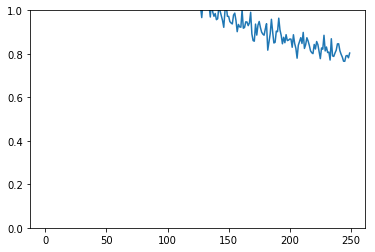

In [29]:
plt.plot(handles[thisscope]["loss_history"][50:])
plt.ylim(0,1)

In [30]:
thisscope="v4-train1001"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v4, averages_1000, "1000_train.tfrec", optname="a")

In [31]:
thisscope="v4-train1001"
with tf.variable_scope(thisscope):
    for i in range(500):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3720703125 %, 	 horiz  0.3583984375 %
batch  10	 fit accuracy: vert  0.369140625 %, 	 horiz  0.3515625 %
batch  20	 fit accuracy: vert  0.5185546875 %, 	 horiz  0.3984375 %
batch  30	 fit accuracy: vert  0.5830078125 %, 	 horiz  0.44140625 %
batch  40	 fit accuracy: vert  0.638671875 %, 	 horiz  0.5068359375 %
batch  50	 fit accuracy: vert  0.6396484375 %, 	 horiz  0.5029296875 %
batch  60	 fit accuracy: vert  0.6904296875 %, 	 horiz  0.515625 %
batch  70	 fit accuracy: vert  0.697265625 %, 	 horiz  0.564453125 %
batch  80	 fit accuracy: vert  0.7607421875 %, 	 horiz  0.6044921875 %
batch  90	 fit accuracy: vert  0.720703125 %, 	 horiz  0.5625 %
batch  100	 fit accuracy: vert  0.76171875 %, 	 horiz  0.6005859375 %
batch  110	 fit accuracy: vert  0.8056640625 %, 	 horiz  0.6435546875 %
batch  120	 fit accuracy: vert  0.77734375 %, 	 horiz  0.607421875 %
batch  130	 fit accuracy: vert  0.8037109375 %, 	 horiz  0.6708984375 %
batch  140	 fit accuracy: vert 

In [32]:
valacc(thisscope, "1000_test.tfrec", averages_1000, 500)

	 validation accuracy: vert  62.0 %, 	 horiz  51.800000000000004 %


(62.0, 51.800000000000004)

(0, 1)

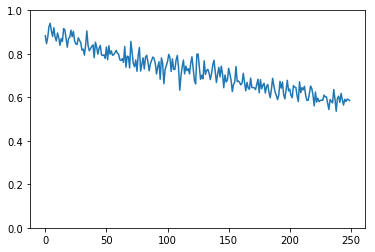

In [38]:
plt.plot(handles[thisscope]["loss_history"][250:])
plt.ylim(0,1)

(0, 2.8)

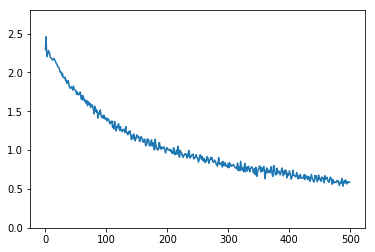

In [39]:
plt.plot(handles[thisscope]["loss_history"][:])
plt.ylim(0,2.8)

In [40]:
valacc(thisscope, "1000_test.tfrec", averages_1000, 1000)

	 validation accuracy: vert  62.6 %, 	 horiz  48.3 %


(62.6, 48.3)

## v4a (previous v4 used appendedmodel 2) and old v5

###### Models definitions

In [12]:

def appended_model_v4_extended(XB,XC,XD, reuse=True):
    '''input: XB,XC, XD - input from layers B,C,D of squeezenet
    returns: layers[0...6]'''
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v2', reuse=reuse):
        x=XD #55x55x16
        with tf.variable_scope('layer0-D'):
            W = tf.get_variable("weights",shape=[1,1,16,10])
            b = tf.get_variable("bias",shape=[10])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 2:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x10
            
        #this now has the same HW dimension as layer C (which is 27x27x32) :
        x = tf.concat([x,XC], 3) #3 is axis   
        with tf.variable_scope('layer3-C'):
            W = tf.get_variable("weights",shape=[1,1,42,24])
            b = tf.get_variable("bias",shape=[24])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 4:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 5:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,1,1,1],padding='VALID')
            layers.append(x)
            # x now is 25x25x12
            
        with tf.variable_scope('layerc-b'):
            W = tf.get_variable("weights",shape=[1,1,12,12])
            b = tf.get_variable("bias",shape=[12])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 6:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 7:
            x = tf.nn.max_pool(x,[1,13,13,1],strides=[1,1,1,1],padding='VALID')
            layers.append(x)
        
        
        #XB is  13x13x64
        x  = tf.concat([x,XB], 3)   
        with tf.variable_scope('layer6-B'):
            W = tf.get_variable("weights",shape=[1,1,76,24])
            b = tf.get_variable("bias",shape=[24])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 7:
            x = tf.nn.relu(x)
            layers.append(x)
        #x is 13x13x18
        with tf.variable_scope('layer8'):
            W = tf.get_variable("weights",shape=[1,1,24,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 9:
            x = tf.nn.relu(x)
            layers.append(x)
        #x has shape 13x13x18
        
        with tf.variable_scope('layer10'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 11:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #fully connected layer:
        with tf.variable_scope('layer12'):
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)

        with tf.variable_scope('layer13'):
            W = tf.get_variable("weights",shape=[1,1,6,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,13,13,1],"VALID")
            x = tf.nn.bias_add(x,b)
            x = tf.nn.relu(x)
            layers.append(x)

            
            
    return layers, var_list
                
  

In [15]:

def appended_model_v4_avgpool(XB,XC,XD, reuse=True):
    '''input: XB,XC, XD - input from layers B,C,D of squeezenet
    returns: layers[0...6]'''
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v2', reuse=reuse):
        x=XD #55x55x16
        with tf.variable_scope('layer0-D'):
            W = tf.get_variable("weights",shape=[1,1,16,10])
            b = tf.get_variable("bias",shape=[10])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 2:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x10
            
        #this now has the same HW dimension as layer C (which is 27x27x32) :
        x = tf.concat([x,XC], 3) #3 is axis   
        with tf.variable_scope('layer3-C'):
            W = tf.get_variable("weights",shape=[1,1,42,12])
            b = tf.get_variable("bias",shape=[12])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 4:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 5:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 13x13x12
        #XB is  13x13x64
        x  = tf.concat([x,XB], 3)   
        with tf.variable_scope('layer6-B'):
            W = tf.get_variable("weights",shape=[1,1,76,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 7:
            x = tf.nn.relu(x)
            layers.append(x)
        #x is 13x13x18
        with tf.variable_scope('layer8'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 9:
            x = tf.nn.relu(x)
            layers.append(x)
        #x has shape 13x13x18
        
        with tf.variable_scope('layer10'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 11:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #averagepool:
        with tf.variable_scope('layer12'):
            x = tf.nn.avg_pool(x,[1,13,13,1],strides=[1,1,1,1],padding = "VALID")
            layers.append(x)
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            layers.append(x)
    return layers, var_list
                
  

In [11]:
def appended_full_model_v5( filename, averages, batch_size=2, regscale=0., reuse=False):
    #old version - no shuffle control
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    a1,s1,a3,s3,a7,s7=averages
    layers, var_list = appended_model_v4_avgpool( ((nextdict['squeezed_layer_7']-a7)/s7), 
                                          ((nextdict['squeezed_layer_3']-a3)/s3),
                                          ((nextdict['squeezed_layer_1']-a1)/s1), reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    reg_loss = tf.add_n([.5 *regscale * tf.reduce_sum(h**2)   for h in var_list])
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz + reg_loss
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list

In [16]:
def appended_full_model_v5( filename, averages, batch_size=2, regscale=0., reuse=False, shuffle_size=4600):
    #v.2
    
    
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    if shuffle_size != 0:
        assert(shuffle_size>0)
        dsbatched=ds.repeat().shuffle(shuffle_size).batch(batch_size)
    else:
        dsbatched=ds.repeat().batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    a1,s1,a3,s3,a7,s7=averages
    layers, var_list = appended_model_v4_avgpool( ((nextdict['squeezed_layer_7']-a7)/s7), 
                                          ((nextdict['squeezed_layer_3']-a3)/s3),
                                          ((nextdict['squeezed_layer_1']-a1)/s1), reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    reg_loss = tf.add_n([.5 *regscale * tf.reduce_sum(h**2)   for h in var_list])
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz + reg_loss
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list

In [15]:
def appended_full_model_v5_extended( filename, averages, batch_size=2, regscale=0., reuse=False):
    
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    dsbatched=ds.repeat().shuffle(4600).batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    a1,s1,a3,s3,a7,s7=averages
    layers, var_list = appended_model_v4_extended( ((nextdict['squeezed_layer_7']-a7)/s7), 
                                          ((nextdict['squeezed_layer_3']-a3)/s3),
                                          ((nextdict['squeezed_layer_1']-a1)/s1), reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    reg_loss = tf.add_n([.5 *regscale * tf.reduce_sum(h**2)   for h in var_list])
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz + reg_loss
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list

###### v4_averages-1004

In [48]:
thisscope="v4_averages-train1004"
handles[thisscope] = initialize_training_forfunc_averages(thisscope, appended_full_model_v5, averages_1000, "1000_train.tfrec", optname="g")

In [46]:
def valacc_v4(thisscope, filename, averages, batch):

    y , ycor, _, _ = appended_full_model_v5(filename, averages, batch_size=batch, reuse=True)

    y_num, ycor_num = sess.run ([y,ycor])
    a,b = np.mean( np.argmax(y_num[0],axis=1) == ycor_num[0] )*100, np.mean( np.argmax(y_num[1],axis=1) == ycor_num[1] )*100 
    print ("\t validation accuracy: vert ",a,  "%, \t horiz ", b,"%" )
    return a,b

In [50]:
thisscope="v4_averages-train1004"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"] ] )
        
        if i%50==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            c,d = valacc_v4(thisscope, "1000_valid.tfrec", averages_1000, 500)
            
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)

batch  0	 fit accuracy: vert  0.3271484375 %, 	 horiz  0.3447265625 %
	 validation accuracy: vert  36.8 %, 	 horiz  30.4 %
batch  10	 fit accuracy: vert  0.36328125 %, 	 horiz  0.3583984375 %
	 validation accuracy: vert  34.2 %, 	 horiz  34.8 %
batch  20	 fit accuracy: vert  0.3759765625 %, 	 horiz  0.3212890625 %
	 validation accuracy: vert  40.6 %, 	 horiz  35.8 %
batch  30	 fit accuracy: vert  0.345703125 %, 	 horiz  0.390625 %
	 validation accuracy: vert  36.0 %, 	 horiz  39.6 %
batch  40	 fit accuracy: vert  0.421875 %, 	 horiz  0.3720703125 %
	 validation accuracy: vert  43.0 %, 	 horiz  37.8 %
batch  50	 fit accuracy: vert  0.44921875 %, 	 horiz  0.3876953125 %
	 validation accuracy: vert  51.800000000000004 %, 	 horiz  34.2 %
batch  60	 fit accuracy: vert  0.4580078125 %, 	 horiz  0.396484375 %


KeyboardInterrupt: 

### train and validation simultaneously

#### v5-try1

In [17]:
thisscope="v5-try1"
handles[thisscope] = initialize_training_forfunc_averages_validtn(thisscope, appended_full_model_v5, averages_1000, "1000_train.tfrec", "1000_valid.tfrec", optname="a")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [18]:
thisscope="v5-try1"
with tf.variable_scope(thisscope):
    for i in range(300):
        if i%10==0:
            print ("batch ",i,end="")
        _, loss_value, y, cor_y, val_his = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                             handles[thisscope]["val_loss"]] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%" )
            #handles[thisscope]["fit_history"].append((a,b))
            #handles[thisscope]["val_history"].append(valacc(thisscope, "noflip160_valid.tfrec", averages_nf160, 2000))
        handles[thisscope]["loss_history"].append(loss_value)
        handles[thisscope]["val_history"].append(val_his)

batch  0	 fit accuracy: vert  0.322265625 %, 	 horiz  0.3408203125 %
batch  10	 fit accuracy: vert  0.341796875 %, 	 horiz  0.3447265625 %
batch  20	 fit accuracy: vert  0.32421875 %, 	 horiz  0.3564453125 %
batch  30	 fit accuracy: vert  0.435546875 %, 	 horiz  0.369140625 %
batch  40	 fit accuracy: vert  0.43359375 %, 	 horiz  0.38671875 %
batch  50	 fit accuracy: vert  0.4580078125 %, 	 horiz  0.3857421875 %
batch  60	 fit accuracy: vert  0.4765625 %, 	 horiz  0.43359375 %
batch  70	 fit accuracy: vert  0.5009765625 %, 	 horiz  0.439453125 %
batch  80	 fit accuracy: vert  0.5615234375 %, 	 horiz  0.4228515625 %
batch  90	 fit accuracy: vert  0.5615234375 %, 	 horiz  0.43359375 %
batch  100	 fit accuracy: vert  0.5537109375 %, 	 horiz  0.4326171875 %
batch  110	 fit accuracy: vert  0.5849609375 %, 	 horiz  0.4599609375 %
batch  120	 fit accuracy: vert  0.6171875 %, 	 horiz  0.466796875 %
batch  130	 fit accuracy: vert  0.6220703125 %, 	 horiz  0.4833984375 %
batch  140	 fit accuracy:

## v5 rerun

### Models definitions

In [13]:
def appended_model_v5(XB,XC,XD, reuse=True):
    # same as appended_model_v4_avgpool
    '''input: XB,XC, XD - input from layers B,C,D of squeezenet
    returns: layers[0...6]'''
    layers=[]
    var_list=[] # list of variable tensors so that we can initialize variables for a particular model
    with tf.variable_scope('my_v2', reuse=reuse):
        x=XD #55x55x16
        with tf.variable_scope('layer0-D'):
            W = tf.get_variable("weights",shape=[1,1,16,10])
            b = tf.get_variable("bias",shape=[10])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 1:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 2:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 27x27x10
            
        #this now has the same HW dimension as layer C (which is 27x27x32) :
        x = tf.concat([x,XC], 3) #3 is axis   
        with tf.variable_scope('layer3-C'):
            W = tf.get_variable("weights",shape=[1,1,42,12])
            b = tf.get_variable("bias",shape=[12])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 4:
            x = tf.nn.relu(x)
            layers.append(x)
            #layer 5:
            x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
            layers.append(x)
            # x now is 13x13x12
        #XB is  13x13x64
        x  = tf.concat([x,XB], 3)   
        with tf.variable_scope('layer6-B'):
            W = tf.get_variable("weights",shape=[1,1,76,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 7:
            x = tf.nn.relu(x)
            layers.append(x)
        #x is 13x13x18
        with tf.variable_scope('layer8'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 9:
            x = tf.nn.relu(x)
            layers.append(x)
        #x has shape 13x13x18
        
        with tf.variable_scope('layer10'):
            W = tf.get_variable("weights",shape=[1,1,18,18])
            b = tf.get_variable("bias",shape=[18])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            x = tf.nn.bias_add(x,b)
            layers.append(x)
            #layer 11:
            x = tf.nn.relu(x)
            layers.append(x)
        #
        #averagepool:
        with tf.variable_scope('layer12'):
            x = tf.nn.avg_pool(x,[1,13,13,1],strides=[1,1,1,1],padding = "VALID")
            layers.append(x)
            W = tf.get_variable("weights",shape=[1,1,18,6])
            b = tf.get_variable("bias",shape=[6])
            var_list.append(W)
            var_list.append(b)
            x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
            layers.append(x)
    return layers, var_list
                
  

In [14]:
def appended_full_model_v5( filename, averages, batch_size=2, regscale=0., reuse=False, shuffle_size=4600):
    #v.2
    
    
    #no coordinates
    ds=dataset_XYclassif_from_TFRecord( layer_name_and_shape_list=[    ("squeezed_layer_1", 55, 55, 16), 
                                                                ("squeezed_layer_3", 27, 27, 32),
                                                                ("squeezed_layer_7", 13, 13, 64)  ], filename=filename )
    if shuffle_size != 0:
        assert(shuffle_size>0)
        dsbatched=ds.repeat().shuffle(shuffle_size).batch(batch_size)
    else:
        dsbatched=ds.repeat().batch(batch_size)
    iterator= dsbatched.make_one_shot_iterator()
    nextdict=iterator.get_next()
    a1,s1,a3,s3,a7,s7=averages
    layers, var_list = appended_model_v5( ((nextdict['squeezed_layer_7']-a7)/s7), 
                                          ((nextdict['squeezed_layer_3']-a3)/s3),
                                          ((nextdict['squeezed_layer_1']-a1)/s1), reuse )
    y=tf.reshape(layers[-1],[-1,6])
    y_vert = y[:,:3]
    y_horiz = y[:,3:]
    
    reg_loss = tf.add_n([.5 *regscale * tf.reduce_sum(h**2)   for h in var_list])
    
    loss_vert = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_vert'], 3), 
                                                                        logits=y_vert
                                                                       ))
    loss_horiz = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(nextdict['class_horiz'], 3), 
                                                                        logits=y_horiz
                                                                       ))
    loss = loss_vert + loss_horiz + reg_loss
    
    return (y_vert,y_horiz), (nextdict['class_vert'],nextdict['class_horiz']), loss, var_list

### v5-try1-rerun

#### initialize

note originally did not specify shuffle_size (i.e. shuffle_size=4600 by default), changed to shuffle_size=0 when model restored from checkpoint (below)

In [24]:
thisscope="v5-try1rb"
handles[thisscope] = initialize_training_forfunc_averages_validtn_v2(thisscope, appended_full_model_v5, averages_1000,
                                                                     "1000_train.tfrec", "1000_valid.tfrec",  
                                                                     optname="b", shuffle_size=0, validate=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



##### start training

batch  0	 fit accuracy: vert  0.3828125 %, 	 horiz  0.3271484375 %	 val accuracy: vert  0.3232421875 %, 	 horiz  0.3115234375 %


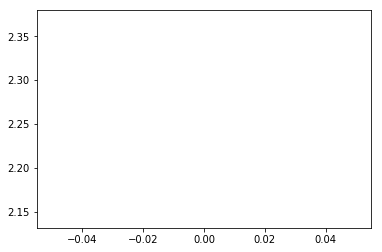

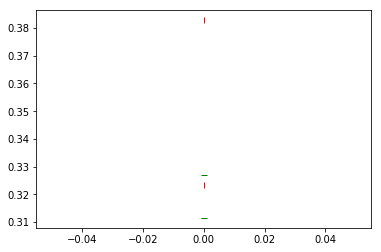

batch  5	 fit accuracy: vert  0.3369140625 %, 	 horiz  0.341796875 %	 val accuracy: vert  0.3515625 %, 	 horiz  0.31640625 %
batch  10	 fit accuracy: vert  0.3564453125 %, 	 horiz  0.3671875 %	 val accuracy: vert  0.3681640625 %, 	 horiz  0.337890625 %
batch  15	 fit accuracy: vert  0.3974609375 %, 	 horiz  0.333984375 %	 val accuracy: vert  0.3740234375 %, 	 horiz  0.3330078125 %
batch  20	 fit accuracy: vert  0.4775390625 %, 	 horiz  0.3486328125 %	 val accuracy: vert  0.458984375 %, 	 horiz  0.33203125 %
batch  25	 fit accuracy: vert  0.4921875 %, 	 horiz  0.357421875 %	 val accuracy: vert  0.5146484375 %, 	 horiz  0.3818359375 %
batch  30	 fit accuracy: vert  0.435546875 %, 	 horiz  0.396484375 %	 val accuracy: vert  0.421875 %, 	 horiz  0.359375 %
batch  35	 fit accuracy: vert  0.4951171875 %, 	 horiz  0.369140625 %	 val accuracy: vert  0.4736328125 %, 	 horiz  0.365234375 %
batch  40	 fit accuracy: vert  0.5263671875 %, 	 horiz  0.3896484375 %	 val accuracy: vert  0.5498046875 %,

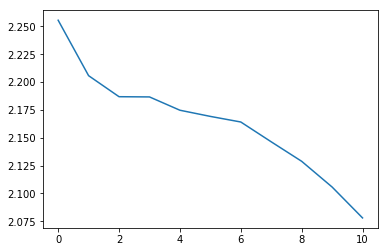

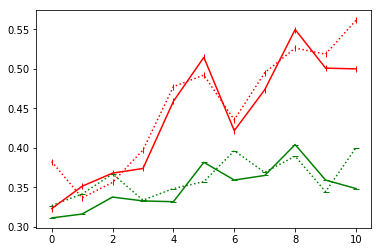

batch  55	 fit accuracy: vert  0.57421875 %, 	 horiz  0.3857421875 %	 val accuracy: vert  0.6083984375 %, 	 horiz  0.4150390625 %
batch  60	 fit accuracy: vert  0.50390625 %, 	 horiz  0.34765625 %	 val accuracy: vert  0.53515625 %, 	 horiz  0.3603515625 %
batch  65	 fit accuracy: vert  0.607421875 %, 	 horiz  0.375 %	 val accuracy: vert  0.537109375 %, 	 horiz  0.3486328125 %
batch  70	 fit accuracy: vert  0.5966796875 %, 	 horiz  0.4013671875 %	 val accuracy: vert  0.611328125 %, 	 horiz  0.4169921875 %
batch  75	 fit accuracy: vert  0.603515625 %, 	 horiz  0.40625 %	 val accuracy: vert  0.5341796875 %, 	 horiz  0.3798828125 %
batch  80	 fit accuracy: vert  0.5908203125 %, 	 horiz  0.3740234375 %	 val accuracy: vert  0.5712890625 %, 	 horiz  0.3603515625 %
batch  85	 fit accuracy: vert  0.5537109375 %, 	 horiz  0.3974609375 %	 val accuracy: vert  0.6474609375 %, 	 horiz  0.4560546875 %
batch  90	 fit accuracy: vert  0.623046875 %, 	 horiz  0.37890625 %	 val accuracy: vert  0.581054687

In [25]:
thisscope="v5-try1rb"
with tf.variable_scope(thisscope):
    for i in range(100):
        if i%5==0:
            print ("batch ",i,end="")
            
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                            ] )
        
        if i%5==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%", end='' )
            handles[thisscope]["loss_history"].append(loss_value)
            handles[thisscope]["fit_history"].append((a,b))
            vloss_value, vy, vcor_y = sess.run([ handles[thisscope]["val_loss"],
                                              handles[thisscope]["val_y"],
                                              handles[thisscope]["val_correct_y"],
                                            ] )
            va,vb =  (np.mean( np.argmax(vy[0],axis=1) == vcor_y[0] ),np.mean( np.argmax(vy[1],axis=1) == vcor_y[1] ))
            print ("\t val accuracy: vert ", va, "%, \t horiz ",vb , "%" )
#            handles[thisscope]["val_loss_history"].append(loss_value)
            handles[thisscope]["val_history"].append((va,vb))

        if i%50 == 0:
            plt.plot(handles[thisscope]["loss_history"]); 
            plt.show()
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
            plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
            plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
            plt.show()

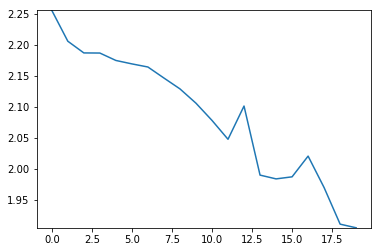

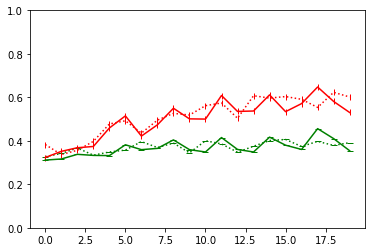

In [26]:
plt.plot(handles[thisscope]["loss_history"]); 
plt.ylim(min(handles[thisscope]["loss_history"]), min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"])))
plt.show()
plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
plt.ylim(0,1)
plt.show()

##### offtopic - estimate Nimages in tfrec (i.e. how large an epoch should be):

In [51]:
!dir *tfrec


 Volume in drive C is TI10693600D
 Volume Serial Number is B401-2245

 Directory of C:\Users\Sergey\NeuralNetworks\fromSqueezeNet

10/22/2018  09:31 PM                 0 try1.tfrec
10/30/2018  07:17 PM       200,176,128 XandY.tfrec
10/28/2018  08:02 PM            86,882 XandY1.tfrec
12/31/2018  12:42 AM     1,522,579,968 XBCDandY_9.tfrec
01/07/2019  12:27 AM       338,351,104 XnormBCDandY_2.tfrec
01/06/2019  11:47 PM       200,176,128 XnormBCDandY_9.tfrec
01/08/2019  12:55 AM   152,257,996,800 XnormBCDandY_90.tfrec
               7 File(s) 154,519,367,010 bytes
               0 Dir(s)  331,605,184,512 bytes free


In [65]:
(55* 55*16 + 27*27*32 + 13*13*64) / (13*13*64)

7.631656804733728

In [73]:
file_size_per_example_layerD = 86882//2
file_size_per_example_layersBCD = file_size_per_example_layerD*7.6062
this_file_size = 338351104
#this_file_size = 1979519488
print("total examples:", this_file_size/file_size_per_example_layersBCD)

total examples: 1024.000203919283


In [74]:
!dir datasets1

 Volume in drive C is TI10693600D
 Volume Serial Number is B401-2245

 Directory of C:\Users\Sergey\NeuralNetworks\fromSqueezeNet\datasets1

02/18/2019  04:13 PM    <DIR>          .
02/18/2019  04:13 PM    <DIR>          ..
02/18/2019  04:12 PM       335,707,736 1000_test.tfrec
02/18/2019  11:34 AM     2,064,800,829 1000_train.tfrec
02/18/2019  04:13 PM     1,007,784,050 1000_valid.tfrec
02/18/2019  04:00 PM           502,175 fromSqueezeNet-v8p2.ipynb
02/18/2019  04:15 PM    <DIR>          tfrec
02/18/2019  11:20 AM       283,271,639 tfrec-20190218T191527Z-001.zip
               5 File(s)  3,692,066,429 bytes
               3 Dir(s)  331,605,180,416 bytes free


In [75]:
this_file_size = 335707736
print("test examples:", this_file_size/file_size_per_example_layersBCD)
this_file_size = 1007784050
print("validation examples:", this_file_size/file_size_per_example_layersBCD)
this_file_size = 2007784050
print("training examples:", this_file_size/file_size_per_example_layersBCD)

test examples: 1016.0002023261636
validation examples: 3050.0006073767704
training examples: 6076.443234025575


In [76]:
print("something must be wrong, since for training set the number is not integer")

something must be wrong, since for training set the number is not integer


##### continue training

continue training - note the first 20 plot points = 100 batches=~16 epochs did not correctly save val history
batch  0	 fit accuracy: vert  0.58203125 %, 	 horiz  0.427734375 %	 val accuracy: vert  0.65234375 %, 	 horiz  0.48046875 %


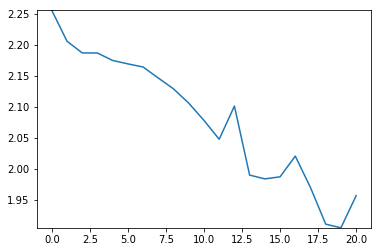

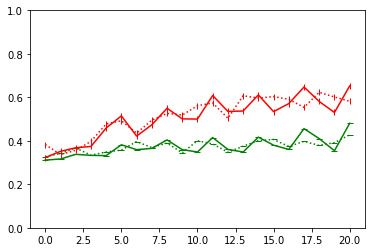

batch  5	 fit accuracy: vert  0.650390625 %, 	 horiz  0.40625 %	 val accuracy: vert  0.5859375 %, 	 horiz  0.40234375 %
batch  10	 fit accuracy: vert  0.6259765625 %, 	 horiz  0.427734375 %	 val accuracy: vert  0.578125 %, 	 horiz  0.3662109375 %
batch  15	 fit accuracy: vert  0.5703125 %, 	 horiz  0.41015625 %	 val accuracy: vert  0.6669921875 %, 	 horiz  0.470703125 %
batch  20	 fit accuracy: vert  0.6923828125 %, 	 horiz  0.400390625 %	 val accuracy: vert  0.6044921875 %, 	 horiz  0.41015625 %
batch  25	 fit accuracy: vert  0.65625 %, 	 horiz  0.4501953125 %	 val accuracy: vert  0.5888671875 %, 	 horiz  0.3671875 %
batch  30	 fit accuracy: vert  0.6435546875 %, 	 horiz  0.4169921875 %	 val accuracy: vert  0.6630859375 %, 	 horiz  0.4765625 %
batch  35	 fit accuracy: vert  0.6435546875 %, 	 horiz  0.396484375 %	 val accuracy: vert  0.6025390625 %, 	 horiz  0.4140625 %
batch  40	 fit accuracy: vert  0.6240234375 %, 	 horiz  0.4189453125 %	 val accuracy: vert  0.5947265625 %, 	 horiz  

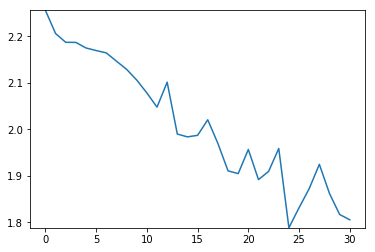

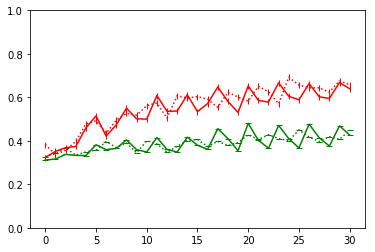

batch  55	 fit accuracy: vert  0.6513671875 %, 	 horiz  0.4501953125 %	 val accuracy: vert  0.623046875 %, 	 horiz  0.3720703125 %
batch  60	 fit accuracy: vert  0.6806640625 %, 	 horiz  0.4111328125 %	 val accuracy: vert  0.658203125 %, 	 horiz  0.47265625 %
batch  65	 fit accuracy: vert  0.66015625 %, 	 horiz  0.435546875 %	 val accuracy: vert  0.662109375 %, 	 horiz  0.4501953125 %
batch  70	 fit accuracy: vert  0.666015625 %, 	 horiz  0.4287109375 %	 val accuracy: vert  0.6298828125 %, 	 horiz  0.3779296875 %
batch  75	 fit accuracy: vert  0.71484375 %, 	 horiz  0.4228515625 %	 val accuracy: vert  0.681640625 %, 	 horiz  0.451171875 %
batch  80	 fit accuracy: vert  0.673828125 %, 	 horiz  0.478515625 %	 val accuracy: vert  0.6533203125 %, 	 horiz  0.451171875 %
batch  85	 fit accuracy: vert  0.685546875 %, 	 horiz  0.44140625 %	 val accuracy: vert  0.6513671875 %, 	 horiz  0.37890625 %
batch  90	 fit accuracy: vert  0.6435546875 %, 	 horiz  0.4609375 %	 val accuracy: vert  0.702148

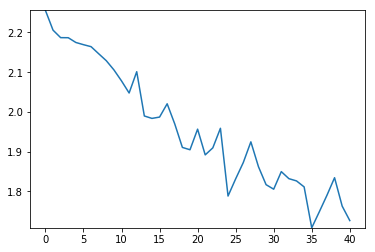

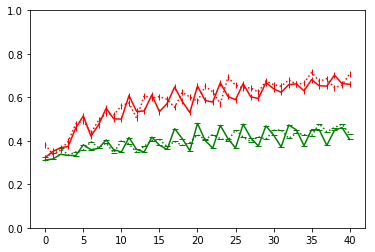

batch  105	 fit accuracy: vert  0.70703125 %, 	 horiz  0.451171875 %	 val accuracy: vert  0.7080078125 %, 	 horiz  0.4453125 %
batch  110	 fit accuracy: vert  0.6826171875 %, 	 horiz  0.4697265625 %	 val accuracy: vert  0.6708984375 %, 	 horiz  0.46875 %
batch  115	 fit accuracy: vert  0.708984375 %, 	 horiz  0.44140625 %	 val accuracy: vert  0.6630859375 %, 	 horiz  0.3994140625 %
batch  120	 fit accuracy: vert  0.6728515625 %, 	 horiz  0.447265625 %	 val accuracy: vert  0.7158203125 %, 	 horiz  0.447265625 %
batch  125	 fit accuracy: vert  0.6689453125 %, 	 horiz  0.4765625 %	 val accuracy: vert  0.6845703125 %, 	 horiz  0.4716796875 %
batch  130	 fit accuracy: vert  0.7373046875 %, 	 horiz  0.4404296875 %	 val accuracy: vert  0.66015625 %, 	 horiz  0.4169921875 %
batch  135	 fit accuracy: vert  0.6865234375 %, 	 horiz  0.4794921875 %	 val accuracy: vert  0.712890625 %, 	 horiz  0.4521484375 %
batch  140	 fit accuracy: vert  0.712890625 %, 	 horiz  0.451171875 %	 val accuracy: vert  

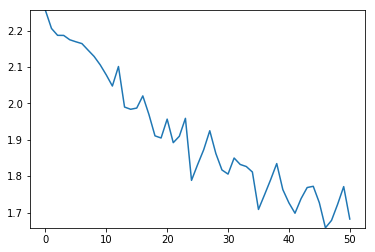

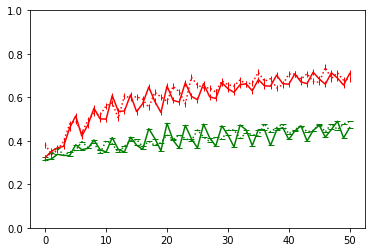

batch  155	 fit accuracy: vert  0.7314453125 %, 	 horiz  0.4404296875 %	 val accuracy: vert  0.705078125 %, 	 horiz  0.498046875 %
batch  160	 fit accuracy: vert  0.755859375 %, 	 horiz  0.4404296875 %	 val accuracy: vert  0.646484375 %, 	 horiz  0.4306640625 %
batch  165	 fit accuracy: vert  0.7060546875 %, 	 horiz  0.490234375 %	 val accuracy: vert  0.7158203125 %, 	 horiz  0.4765625 %
batch  170	 fit accuracy: vert  0.73046875 %, 	 horiz  0.458984375 %	 val accuracy: vert  0.71484375 %, 	 horiz  0.5009765625 %
batch  175	 fit accuracy: vert  0.69140625 %, 	 horiz  0.47265625 %	 val accuracy: vert  0.650390625 %, 	 horiz  0.4267578125 %
batch  180	 fit accuracy: vert  0.6875 %, 	 horiz  0.521484375 %	 val accuracy: vert  0.7080078125 %, 	 horiz  0.4765625 %
batch  185	 fit accuracy: vert  0.7548828125 %, 	 horiz  0.46484375 %	 val accuracy: vert  0.7265625 %, 	 horiz  0.4931640625 %
batch  190	 fit accuracy: vert  0.71875 %, 	 horiz  0.5087890625 %	 val accuracy: vert  0.6435546875 %

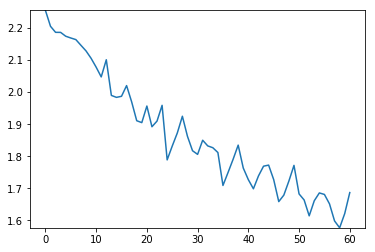

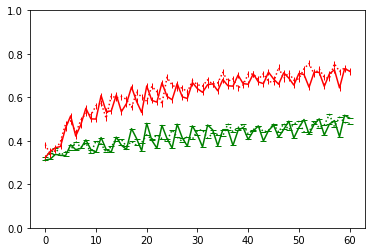

batch  205	 fit accuracy: vert  0.7119140625 %, 	 horiz  0.5107421875 %	 val accuracy: vert  0.6474609375 %, 	 horiz  0.443359375 %
batch  210	 fit accuracy: vert  0.740234375 %, 	 horiz  0.4833984375 %	 val accuracy: vert  0.7119140625 %, 	 horiz  0.5009765625 %
batch  215	 fit accuracy: vert  0.7470703125 %, 	 horiz  0.505859375 %	 val accuracy: vert  0.716796875 %, 	 horiz  0.5029296875 %
batch  220	 fit accuracy: vert  0.71875 %, 	 horiz  0.501953125 %	 val accuracy: vert  0.6611328125 %, 	 horiz  0.44140625 %
batch  225	 fit accuracy: vert  0.7509765625 %, 	 horiz  0.5078125 %	 val accuracy: vert  0.72265625 %, 	 horiz  0.515625 %
batch  230	 fit accuracy: vert  0.69140625 %, 	 horiz  0.482421875 %	 val accuracy: vert  0.732421875 %, 	 horiz  0.5009765625 %
batch  235	 fit accuracy: vert  0.7021484375 %, 	 horiz  0.537109375 %	 val accuracy: vert  0.6572265625 %, 	 horiz  0.4482421875 %
batch  240	 fit accuracy: vert  0.7822265625 %, 	 horiz  0.4697265625 %	 val accuracy: vert  0.

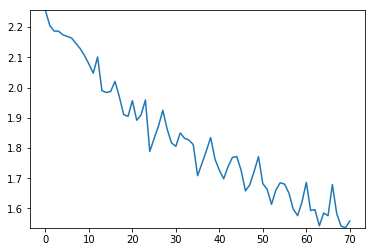

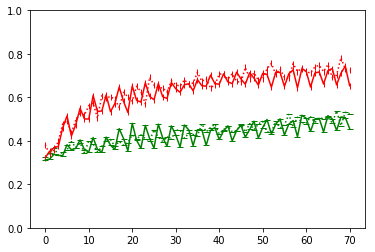

batch  255	 fit accuracy: vert  0.7265625 %, 	 horiz  0.48828125 %	 val accuracy: vert  0.7265625 %, 	 horiz  0.521484375 %
batch  260	 fit accuracy: vert  0.744140625 %, 	 horiz  0.529296875 %	 val accuracy: vert  0.74609375 %, 	 horiz  0.509765625 %
batch  265	 fit accuracy: vert  0.7314453125 %, 	 horiz  0.5283203125 %	 val accuracy: vert  0.65625 %, 	 horiz  0.44140625 %
batch  270	 fit accuracy: vert  0.7939453125 %, 	 horiz  0.5283203125 %	 val accuracy: vert  0.7255859375 %, 	 horiz  0.5322265625 %
batch  275	 fit accuracy: vert  0.75 %, 	 horiz  0.517578125 %	 val accuracy: vert  0.7314453125 %, 	 horiz  0.5087890625 %
batch  280	 fit accuracy: vert  0.7412109375 %, 	 horiz  0.5380859375 %	 val accuracy: vert  0.662109375 %, 	 horiz  0.4541015625 %
batch  285	 fit accuracy: vert  0.712890625 %, 	 horiz  0.4755859375 %	 val accuracy: vert  0.734375 %, 	 horiz  0.5283203125 %
batch  290	 fit accuracy: vert  0.732421875 %, 	 horiz  0.5458984375 %	 val accuracy: vert  0.748046875 %

In [27]:

thisscope="v5-try1rb"

print( "continue training - note the first 20 plot points = 100 batches=~16 epochs did not correctly save val history")

with tf.variable_scope(thisscope):
    for i in range(300):
        if i%5==0:
            print ("batch ",i,end="")
            
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                            ] )
        
        if i%5==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%", end='' )
            handles[thisscope]["loss_history"].append(loss_value)
            handles[thisscope]["fit_history"].append((a,b))
            vloss_value, vy, vcor_y = sess.run([ handles[thisscope]["val_loss"],
                                              handles[thisscope]["val_y"],
                                              handles[thisscope]["val_correct_y"],
                                            ] )
            va,vb =  (np.mean( np.argmax(vy[0],axis=1) == vcor_y[0] ),np.mean( np.argmax(vy[1],axis=1) == vcor_y[1] ))
            print ("\t val accuracy: vert ", va, "%, \t horiz ",vb , "%" )
            handles[thisscope]["val_history"].append((va,vb))

        if i%50 == 0:
            plt.plot(handles[thisscope]["loss_history"]); 
            plt.ylim(min(handles[thisscope]["loss_history"]), 
                     min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"]))
                    )
            plt.show()
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
            plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
            plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
            plt.ylim(0,1)
            plt.show()

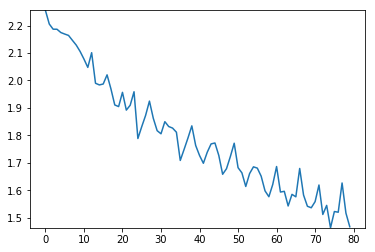

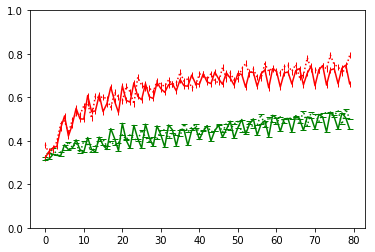

In [28]:
plt.plot(handles[thisscope]["loss_history"]); 
plt.ylim(min(handles[thisscope]["loss_history"]), min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"])))
plt.show()
plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
plt.ylim(0,1)
plt.show()

continue training - note the first 20 plot points = 100 batches=~16 epochs did not correctly save val history
batch  0	 fit accuracy: vert  0.7861328125 %, 	 horiz  0.533203125 %	 val accuracy: vert  0.7060546875 %, 	 horiz  0.4794921875 %


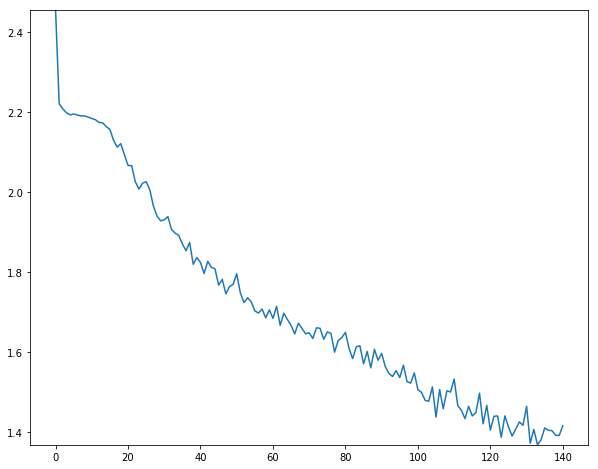

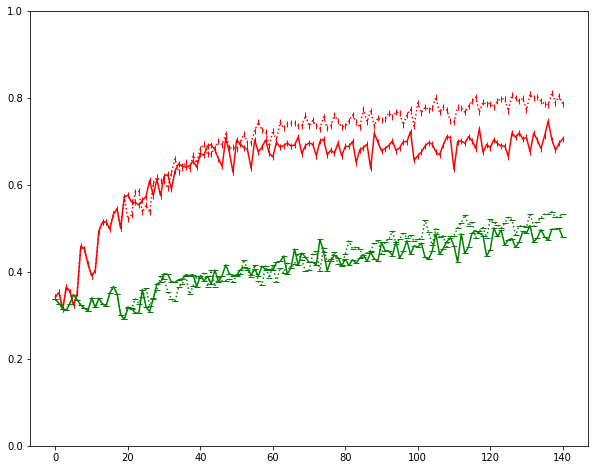

batch  5	 fit accuracy: vert  0.7958984375 %, 	 horiz  0.5703125 %	 val accuracy: vert  0.7109375 %, 	 horiz  0.4833984375 %
batch  10	 fit accuracy: vert  0.7978515625 %, 	 horiz  0.5517578125 %	 val accuracy: vert  0.6865234375 %, 	 horiz  0.5166015625 %
batch  15	 fit accuracy: vert  0.818359375 %, 	 horiz  0.517578125 %	 val accuracy: vert  0.6884765625 %, 	 horiz  0.4931640625 %
batch  20	 fit accuracy: vert  0.8349609375 %, 	 horiz  0.55078125 %	 val accuracy: vert  0.6943359375 %, 	 horiz  0.48046875 %
batch  25	 fit accuracy: vert  0.802734375 %, 	 horiz  0.5400390625 %	 val accuracy: vert  0.7138671875 %, 	 horiz  0.4970703125 %
batch  30	 fit accuracy: vert  0.7919921875 %, 	 horiz  0.5361328125 %	 val accuracy: vert  0.7275390625 %, 	 horiz  0.4951171875 %
batch  35	 fit accuracy: vert  0.7822265625 %, 	 horiz  0.5302734375 %	 val accuracy: vert  0.6962890625 %, 	 horiz  0.48828125 %
batch  40	 fit accuracy: vert  0.818359375 %, 	 horiz  0.5478515625 %	 val accuracy: vert  0

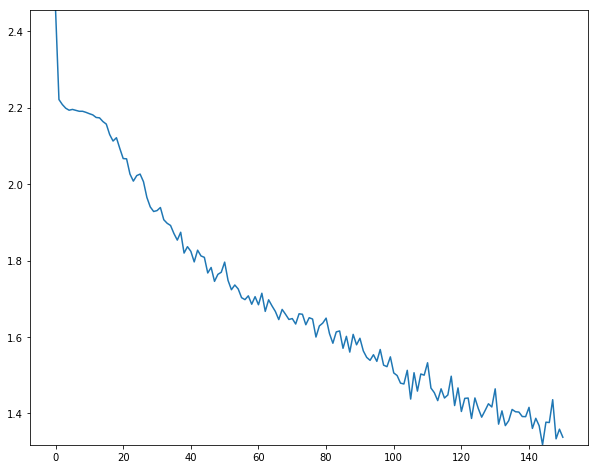

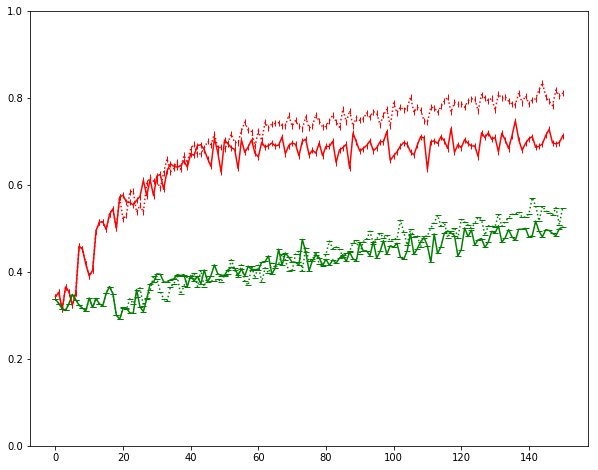

batch  55	 fit accuracy: vert  0.806640625 %, 	 horiz  0.501953125 %	 val accuracy: vert  0.7373046875 %, 	 horiz  0.4736328125 %
batch  60	 fit accuracy: vert  0.78125 %, 	 horiz  0.53515625 %	 val accuracy: vert  0.7275390625 %, 	 horiz  0.51171875 %
batch  65	 fit accuracy: vert  0.8046875 %, 	 horiz  0.537109375 %	 val accuracy: vert  0.71484375 %, 	 horiz  0.5 %
batch  70	 fit accuracy: vert  0.810546875 %, 	 horiz  0.5556640625 %	 val accuracy: vert  0.712890625 %, 	 horiz  0.5078125 %
batch  75	 fit accuracy: vert  0.8095703125 %, 	 horiz  0.533203125 %	 val accuracy: vert  0.7236328125 %, 	 horiz  0.4931640625 %
batch  80	 fit accuracy: vert  0.8408203125 %, 	 horiz  0.5068359375 %	 val accuracy: vert  0.7099609375 %, 	 horiz  0.49609375 %
batch  85	 fit accuracy: vert  0.8134765625 %, 	 horiz  0.52734375 %	 val accuracy: vert  0.6962890625 %, 	 horiz  0.501953125 %
batch  90	 fit accuracy: vert  0.8173828125 %, 	 horiz  0.546875 %	 val accuracy: vert  0.7216796875 %, 	 horiz  

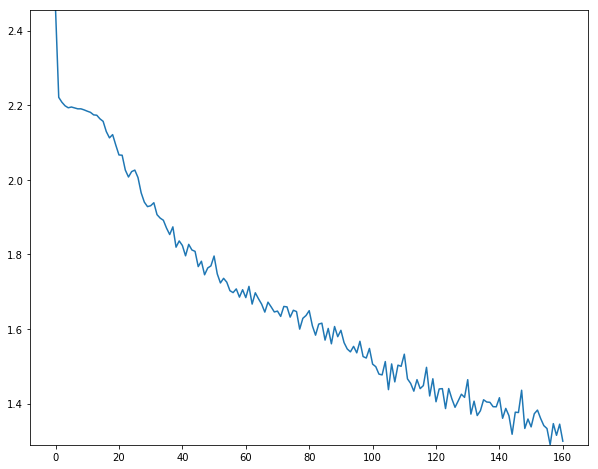

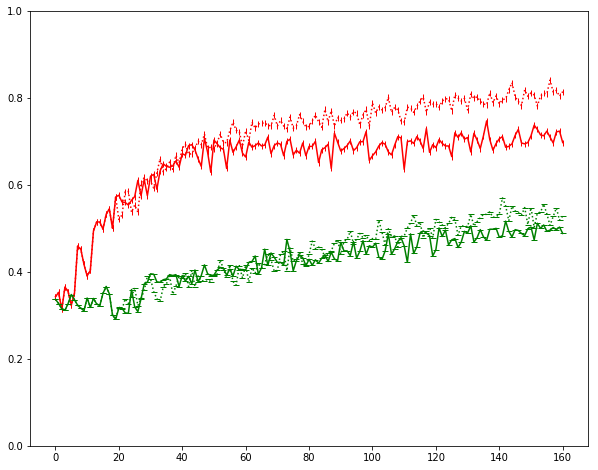

In [79]:

thisscope="v5-try1rb"

print( "continue training - note the first 20 plot points = 100 batches=~16 epochs did not correctly save val history")

with tf.variable_scope(thisscope):
    for i in range(101):
        if i%5==0:
            print ("batch ",i,end="")
            
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                            ] )
        
        if i%5==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%", end='' )
            handles[thisscope]["loss_history"].append(loss_value)
            handles[thisscope]["fit_history"].append((a,b))
            vloss_value, vy, vcor_y = sess.run([ handles[thisscope]["val_loss"],
                                              handles[thisscope]["val_y"],
                                              handles[thisscope]["val_correct_y"],
                                            ] )
            va,vb =  (np.mean( np.argmax(vy[0],axis=1) == vcor_y[0] ),np.mean( np.argmax(vy[1],axis=1) == vcor_y[1] ))
            print ("\t val accuracy: vert ", va, "%, \t horiz ",vb , "%" )
            handles[thisscope]["val_history"].append((va,vb))

        if i%50 == 0:
            plt.plot(handles[thisscope]["loss_history"]); 
            plt.ylim(min(handles[thisscope]["loss_history"]), 
                     min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"]))
                    )
            plt.show()
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
            plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
            plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
            plt.ylim(0,1)
            plt.show()

##### save - original code:

In [29]:
handles[thisscope].keys()

dict_keys(['y', 'correct_y', 'loss', 'train_op', 'loss_history', 'val_history', 'fit_history', 'val_y', 'val_correct_y', 'val_loss'])

In [30]:
tempname='-400steps'
thisscope="v5-try1rb"
handles[thisscope]['saver'] = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=thisscope))
handles[thisscope]['saver'].save(sess, './myckpts/trained-'+thisscope+tempname+'.ckpt', write_meta_graph=False)


'./myckpts/trained-v5-try1rb-400steps.ckpt'

In [31]:
import pickle
with open('./myckpts/trained-'+thisscope+tempname+'.ckpt'+'.handles.pickle', 'wb') as outfile:
    pickle.dump(
        (handles[thisscope]['loss_history'],handles[thisscope]['fit_history'],handles[thisscope]['val_history']),
        outfile)

In [54]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=thisscope)

[<tf.Variable 'v5-try1rb/my_v2/layer0-D/weights:0' shape=(1, 1, 16, 10) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer0-D/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer3-C/weights:0' shape=(1, 1, 42, 12) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer3-C/bias:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer6-B/weights:0' shape=(1, 1, 76, 18) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer6-B/bias:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer8/weights:0' shape=(1, 1, 18, 18) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer8/bias:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer10/weights:0' shape=(1, 1, 18, 18) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer10/bias:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer12/weights:0' shape=(1, 1, 18, 6) dtype=float32_ref>,
 <tf.Variable 'v5-try1rb/my_v2/layer12/bias:0' shape=(6,

##### restore

In [49]:
tempname='-800steps'
thisscope="v5-try1rb"
handles[thisscope]['saver'] = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=thisscope))
handles[thisscope]['saver'].restore(sess, './myckpts/trained-'+thisscope+tempname+'.ckpt')


INFO:tensorflow:Restoring parameters from ./myckpts/trained-v5-try1rb-800steps.ckpt


In [40]:
# tempname='-800steps'
# thisscope="v5-try1rb"
# #avoid restoring optimizer variables:

# thisvars = list( set(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=thisscope)) -
#                  set(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=thisscope+'/'+thisscope)) )

# handles[thisscope]['saver'] = tf.train.Saver(var_list=thisvars)
# handles[thisscope]['saver'].restore(sess, './myckpts/trained-'+thisscope+tempname+'.ckpt')


In [51]:
import pickle
with open('./myckpts/trained-'+thisscope+tempname+'.ckpt'+'.handles.pickle', 'rb') as infile:
    (handles[thisscope]['loss_history'],
     handles[thisscope]['fit_history'],
     handles[thisscope]['val_history']) = pickle.load(infile)

##### try more training - now without shuffle

In [ ]:

thisscope="v5-try1rb"

print( "continue training from checkpoint")

with tf.variable_scope(thisscope):
    for i in range(11):
        if i%5==0:
            print ("batch ",i,end="")
            
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                            ] )
        
        if i%5==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%", end='' )
            handles[thisscope]["loss_history"].append(loss_value)
            handles[thisscope]["fit_history"].append((a,b))
            vloss_value, vy, vcor_y = sess.run([ handles[thisscope]["val_loss"],
                                              handles[thisscope]["val_y"],
                                              handles[thisscope]["val_correct_y"],
                                            ] )
            va,vb =  (np.mean( np.argmax(vy[0],axis=1) == vcor_y[0] ),np.mean( np.argmax(vy[1],axis=1) == vcor_y[1] ))
            print ("\t val accuracy: vert ", va, "%, \t horiz ",vb , "%" )
#            handles[thisscope]["val_loss_history"].append(loss_value)
            handles[thisscope]["val_history"].append((va,vb))

        if i%5 == 0:
            plt.plot(handles[thisscope]["loss_history"]); 
            plt.ylim(min(handles[thisscope]["loss_history"]), 
                     min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"]))
                    )
            plt.show()
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
            plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
            plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
            plt.ylim(0,1)
            plt.show()

##### plot overall training history

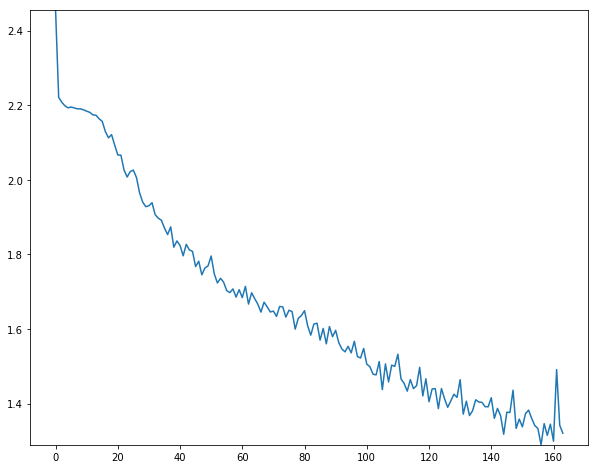

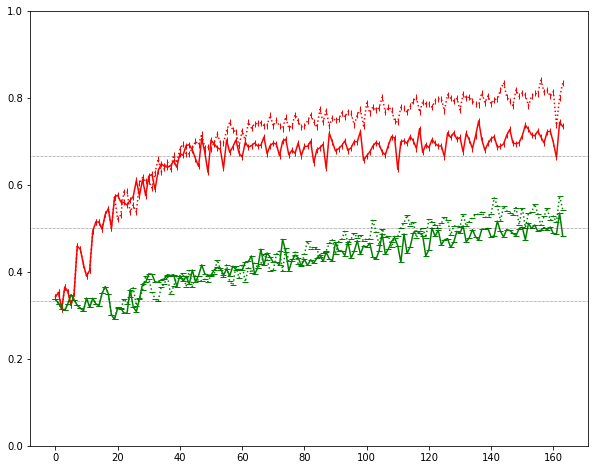

In [56]:
if 1:
    plt.plot(handles[thisscope]["loss_history"]); 
    plt.ylim(min(handles[thisscope]["loss_history"]), 
             min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"]))
            )
    plt.show()
    plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
    plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
    plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
    plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
    plt.ylim(0,1)
    plt.gca().axhline(y=1/3., color='k', linestyle=':',linewidth=0.5)
    plt.gca().axhline(y=1/2., color='k', linestyle=':',linewidth=0.5)
    plt.gca().axhline(y=2/3., color='k', linestyle=':',linewidth=0.5)
    plt.show()

##### save using save function

In [67]:

save_my_model(thisscope, handles, sess,'./myckpts','811steps' )

variables saved:
<tf.Variable 'v5-try1rb/my_v2/layer0-D/weights:0' shape=(1, 1, 16, 10) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer0-D/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer3-C/weights:0' shape=(1, 1, 42, 12) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer3-C/bias:0' shape=(12,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer6-B/weights:0' shape=(1, 1, 76, 18) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer6-B/bias:0' shape=(18,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer8/weights:0' shape=(1, 1, 18, 18) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer8/bias:0' shape=(18,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer10/weights:0' shape=(1, 1, 18, 18) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer10/bias:0' shape=(18,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer12/weights:0' shape=(1, 1, 18, 6) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer12/bias:0' shape=(6,) dtyp

##### restore using restore function

In [74]:
restore_my_model(thisscope, handles, sess,'./myckpts','811steps' )

INFO:tensorflow:Restoring parameters from ./myckpts/trained-v5-try1rb-811steps.ckpt


##### run even more training

In [ ]:

thisscope="v5-try1rb"

print( "continue training - from checkpoint, note that plotting timestep is doubled (after step 162 or so)")

with tf.variable_scope(thisscope):
    for i in range(600):
        if i%10==0:
            print ("batch ",i,end="")
            
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                            ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%", end='' )
            handles[thisscope]["loss_history"].append(loss_value)
            handles[thisscope]["fit_history"].append((a,b))
            vloss_value, vy, vcor_y = sess.run([ handles[thisscope]["val_loss"],
                                              handles[thisscope]["val_y"],
                                              handles[thisscope]["val_correct_y"],
                                            ] )
            va,vb =  (np.mean( np.argmax(vy[0],axis=1) == vcor_y[0] ),np.mean( np.argmax(vy[1],axis=1) == vcor_y[1] ))
            print ("\t val accuracy: vert ", va, "%, \t horiz ",vb , "%" )
            handles[thisscope]["val_history"].append((va,vb))

        if i%50 == 0:
            plt.plot(handles[thisscope]["loss_history"]); 
            plt.ylim(min(handles[thisscope]["loss_history"]), 
                     min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"]))
                    )
            plt.show()
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
            plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
            plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
            plt.ylim(0,1)
            plt.gca().axhline(y=1/3., color='k', linestyle=':',linewidth=0.5)
            plt.gca().axhline(y=1/2., color='k', linestyle=':',linewidth=0.5)
            plt.gca().axhline(y=2/3., color='k', linestyle=':',linewidth=0.5)
            plt.show()

continue training - from checkpoint, note that plotting timestep is doubled (after step 162 or so)
batch  0	 fit accuracy: vert  0.8291015625 %, 	 horiz  0.595703125 %	 val accuracy: vert  0.69140625 %, 	 horiz  0.5234375 %


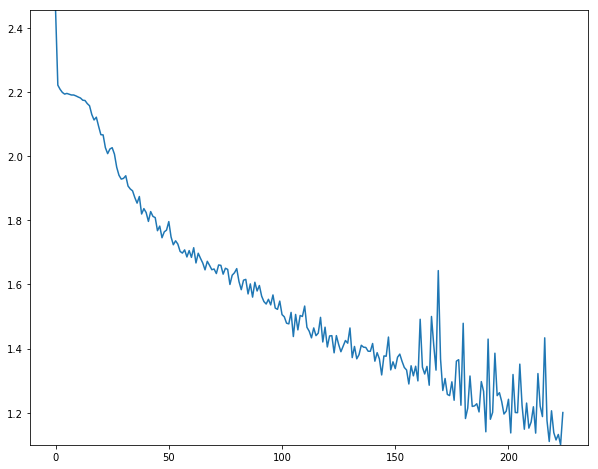

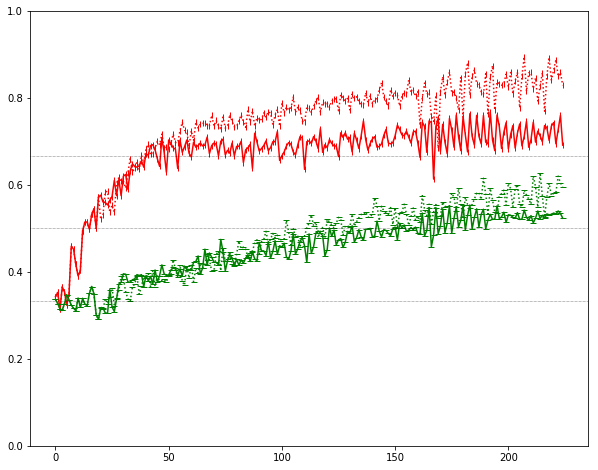

batch  10	 fit accuracy: vert  0.8056640625 %, 	 horiz  0.634765625 %	 val accuracy: vert  0.720703125 %, 	 horiz  0.5458984375 %
batch  20	 fit accuracy: vert  0.8642578125 %, 	 horiz  0.583984375 %	 val accuracy: vert  0.76171875 %, 	 horiz  0.5341796875 %
batch  30	 fit accuracy: vert  0.7734375 %, 	 horiz  0.5693359375 %	 val accuracy: vert  0.6865234375 %, 	 horiz  0.5224609375 %
batch  40	 fit accuracy: vert  0.8486328125 %, 	 horiz  0.59375 %	 val accuracy: vert  0.716796875 %, 	 horiz  0.5517578125 %
batch  50	 fit accuracy: vert  0.888671875 %, 	 horiz  0.599609375 %	 val accuracy: vert  0.7705078125 %, 	 horiz  0.529296875 %


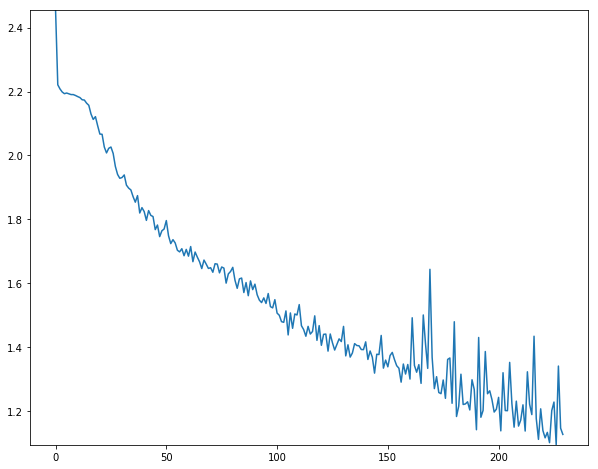

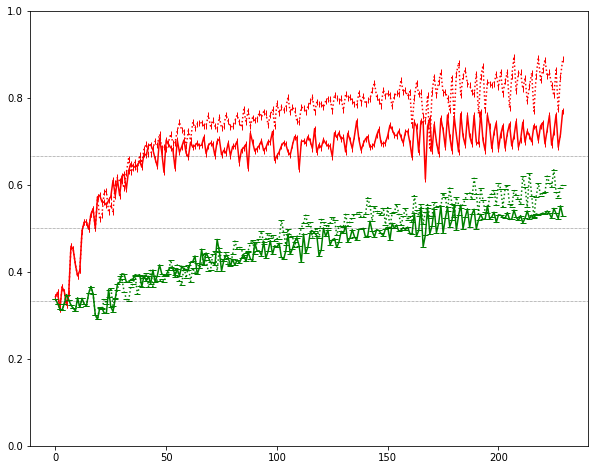

batch  60	 fit accuracy: vert  0.8076171875 %, 	 horiz  0.568359375 %	 val accuracy: vert  0.689453125 %, 	 horiz  0.5244140625 %
batch  70	 fit accuracy: vert  0.865234375 %, 	 horiz  0.5751953125 %	 val accuracy: vert  0.71875 %, 	 horiz  0.5556640625 %
batch  80	 fit accuracy: vert  0.876953125 %, 	 horiz  0.5966796875 %	 val accuracy: vert  0.74609375 %, 	 horiz  0.5283203125 %
batch  90	 fit accuracy: vert  0.83984375 %, 	 horiz  0.625 %	 val accuracy: vert  0.703125 %, 	 horiz  0.5361328125 %
batch  100	 fit accuracy: vert  0.8662109375 %, 	 horiz  0.6064453125 %	 val accuracy: vert  0.7119140625 %, 	 horiz  0.5458984375 %


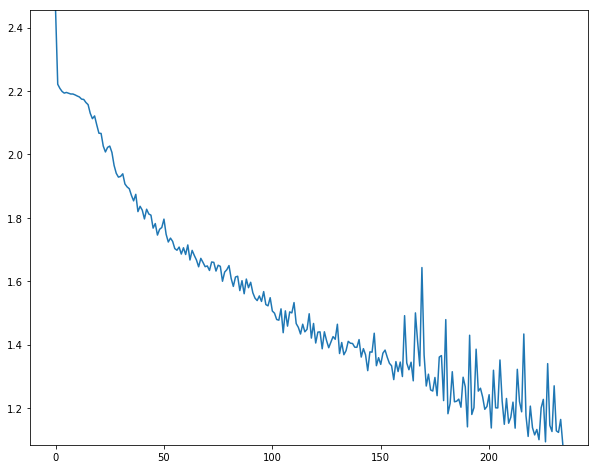

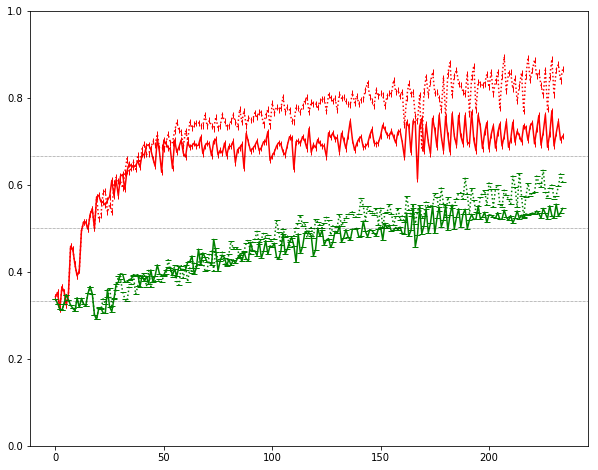

batch  110	 fit accuracy: vert  0.859375 %, 	 horiz  0.5751953125 %	 val accuracy: vert  0.7197265625 %, 	 horiz  0.53125 %
batch  120	 fit accuracy: vert  0.826171875 %, 	 horiz  0.6279296875 %	 val accuracy: vert  0.7216796875 %, 	 horiz  0.5166015625 %
batch  130	 fit accuracy: vert  0.865234375 %, 	 horiz  0.60546875 %	 val accuracy: vert  0.705078125 %, 	 horiz  0.556640625 %
batch  140	 fit accuracy: vert  0.79296875 %, 	 horiz  0.56640625 %	 val accuracy: vert  0.7333984375 %, 	 horiz  0.5224609375 %
batch  150	 fit accuracy: vert  0.8369140625 %, 	 horiz  0.619140625 %	 val accuracy: vert  0.7373046875 %, 	 horiz  0.5498046875 %


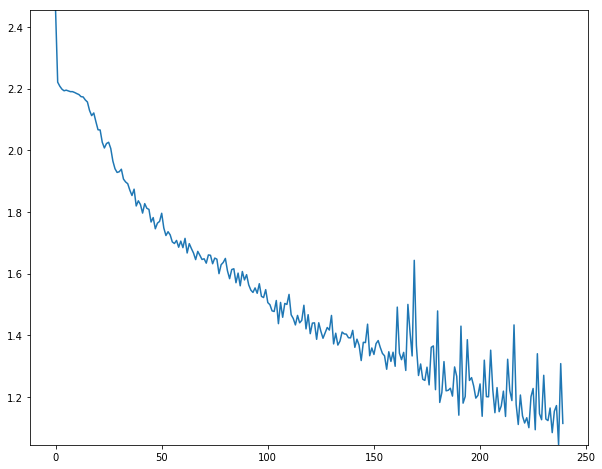

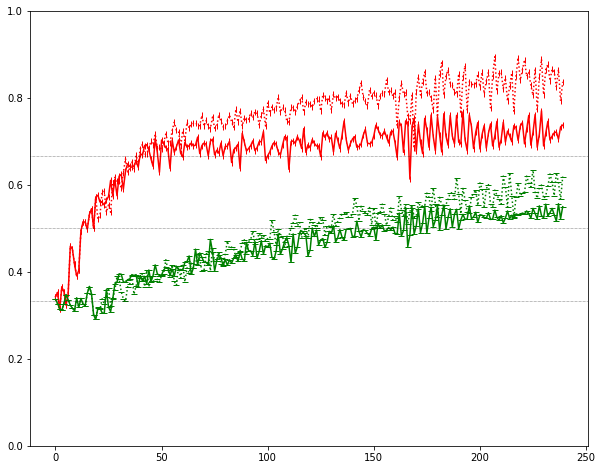

batch  160	 fit accuracy: vert  0.875 %, 	 horiz  0.6044921875 %	 val accuracy: vert  0.669921875 %, 	 horiz  0.53125 %
batch  170	 fit accuracy: vert  0.7861328125 %, 	 horiz  0.587890625 %	 val accuracy: vert  0.7265625 %, 	 horiz  0.5361328125 %
batch  180	 fit accuracy: vert  0.845703125 %, 	 horiz  0.5556640625 %	 val accuracy: vert  0.755859375 %, 	 horiz  0.5263671875 %
batch  190	 fit accuracy: vert  0.9072265625 %, 	 horiz  0.58203125 %	 val accuracy: vert  0.669921875 %, 	 horiz  0.5322265625 %
batch  200	 fit accuracy: vert  0.8359375 %, 	 horiz  0.591796875 %	 val accuracy: vert  0.7021484375 %, 	 horiz  0.5478515625 %


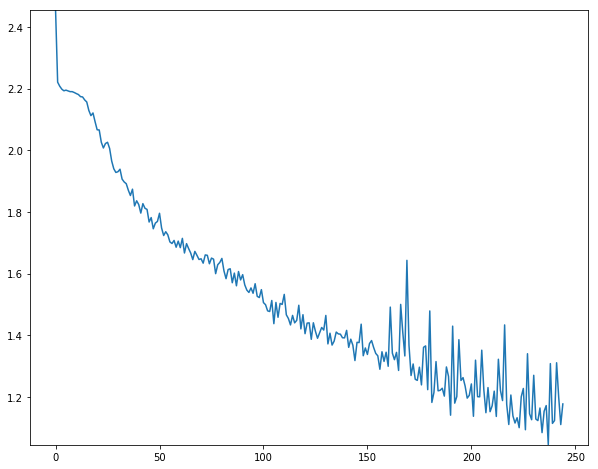

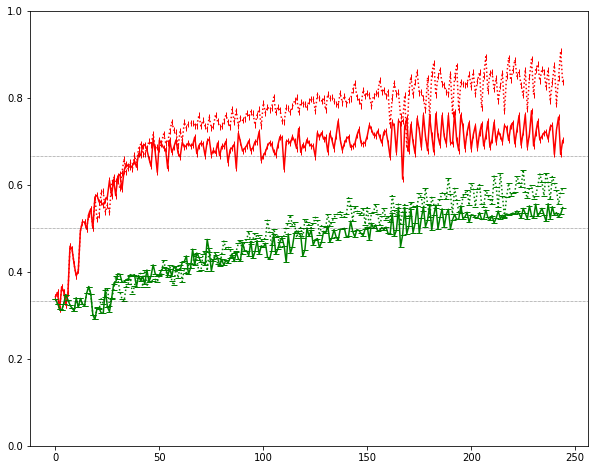

batch  210	 fit accuracy: vert  0.875 %, 	 horiz  0.5966796875 %	 val accuracy: vert  0.7529296875 %, 	 horiz  0.53515625 %
batch  220	 fit accuracy: vert  0.8642578125 %, 	 horiz  0.5634765625 %	 val accuracy: vert  0.724609375 %, 	 horiz  0.5380859375 %
batch  230	 fit accuracy: vert  0.8447265625 %, 	 horiz  0.6357421875 %	 val accuracy: vert  0.70703125 %, 	 horiz  0.53515625 %
batch  240	 fit accuracy: vert  0.84765625 %, 	 horiz  0.615234375 %	 val accuracy: vert  0.7294921875 %, 	 horiz  0.5419921875 %
batch  250	 fit accuracy: vert  0.8134765625 %, 	 horiz  0.591796875 %	 val accuracy: vert  0.7236328125 %, 	 horiz  0.5390625 %


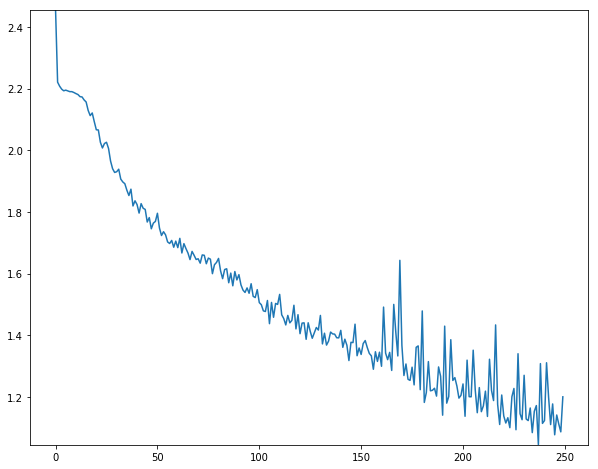

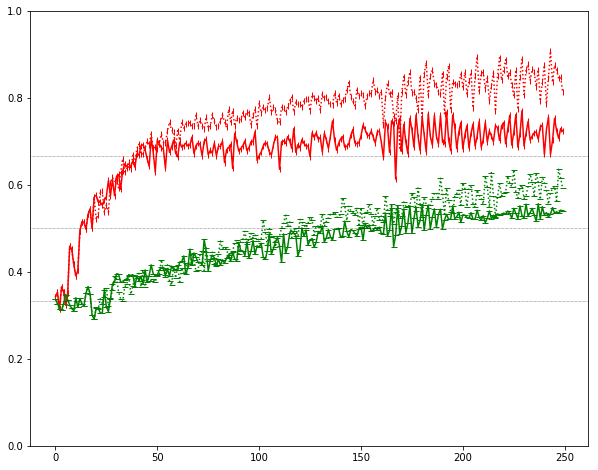

batch  260	 fit accuracy: vert  0.8310546875 %, 	 horiz  0.6318359375 %	 val accuracy: vert  0.736328125 %, 	 horiz  0.537109375 %
batch  270	 fit accuracy: vert  0.8740234375 %, 	 horiz  0.6044921875 %	 val accuracy: vert  0.734375 %, 	 horiz  0.544921875 %
batch  280	 fit accuracy: vert  0.7822265625 %, 	 horiz  0.5791015625 %	 val accuracy: vert  0.728515625 %, 	 horiz  0.5302734375 %
batch  290	 fit accuracy: vert  0.8466796875 %, 	 horiz  0.5927734375 %	 val accuracy: vert  0.7109375 %, 	 horiz  0.5234375 %
batch  300	 fit accuracy: vert  0.9091796875 %, 	 horiz  0.5966796875 %	 val accuracy: vert  0.755859375 %, 	 horiz  0.5478515625 %


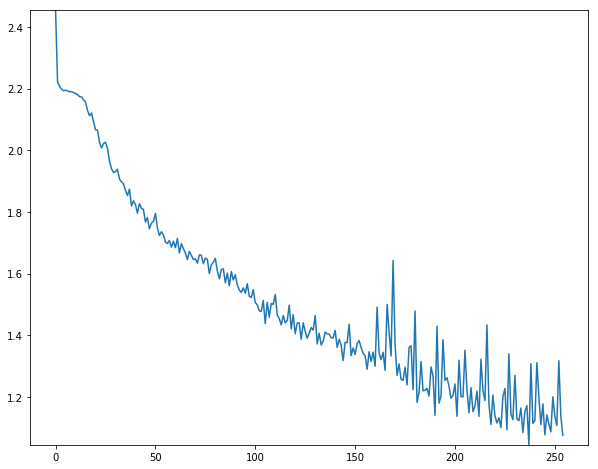

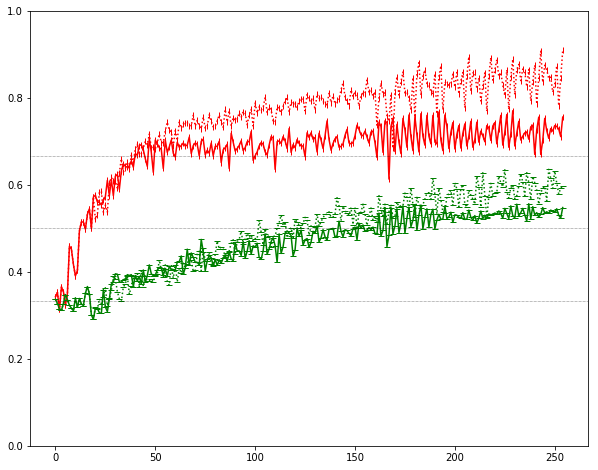

batch  310	 fit accuracy: vert  0.859375 %, 	 horiz  0.60546875 %	 val accuracy: vert  0.73046875 %, 	 horiz  0.525390625 %
batch  320	 fit accuracy: vert  0.869140625 %, 	 horiz  0.615234375 %	 val accuracy: vert  0.6943359375 %, 	 horiz  0.5283203125 %
batch  330	 fit accuracy: vert  0.8994140625 %, 	 horiz  0.5927734375 %	 val accuracy: vert  0.7705078125 %, 	 horiz  0.5498046875 %
batch  340	 fit accuracy: vert  0.873046875 %, 	 horiz  0.640625 %	 val accuracy: vert  0.73828125 %, 	 horiz  0.537109375 %
batch  350	 fit accuracy: vert  0.8642578125 %, 	 horiz  0.615234375 %	 val accuracy: vert  0.69921875 %, 	 horiz  0.5322265625 %


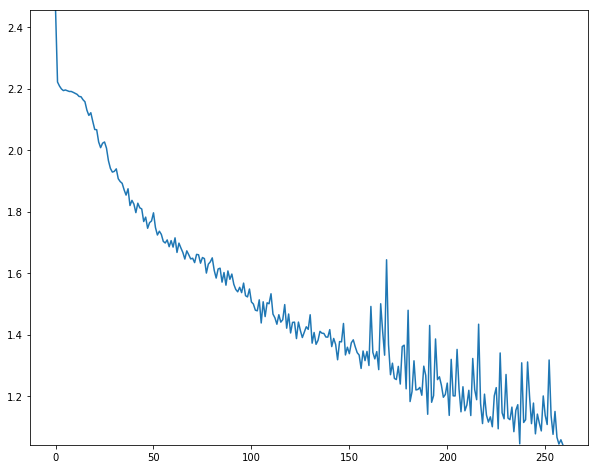

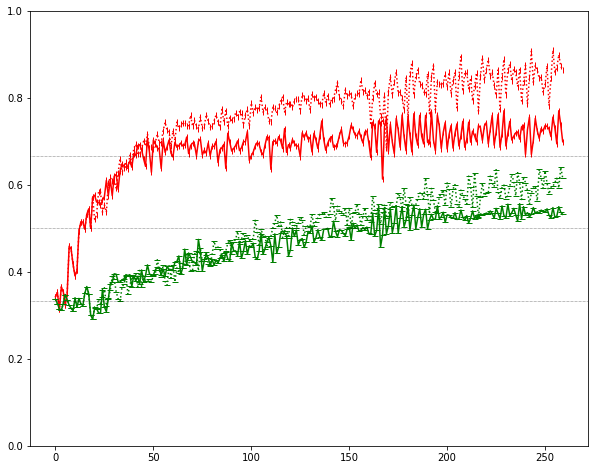

batch  360	 fit accuracy: vert  0.837890625 %, 	 horiz  0.6181640625 %	 val accuracy: vert  0.76953125 %, 	 horiz  0.5517578125 %
batch  370	 fit accuracy: vert  0.8125 %, 	 horiz  0.6591796875 %	 val accuracy: vert  0.7333984375 %, 	 horiz  0.53515625 %
batch  380	 fit accuracy: vert  0.8642578125 %, 	 horiz  0.583984375 %	 val accuracy: vert  0.7158203125 %, 	 horiz  0.5322265625 %
batch  390	 fit accuracy: vert  0.7939453125 %, 	 horiz  0.58203125 %	 val accuracy: vert  0.7578125 %, 	 horiz  0.55078125 %
batch  400	 fit accuracy: vert  0.8681640625 %, 	 horiz  0.6064453125 %	 val accuracy: vert  0.7373046875 %, 	 horiz  0.51953125 %


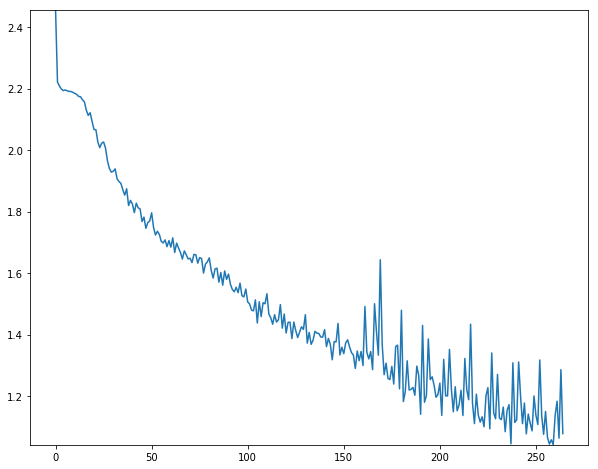

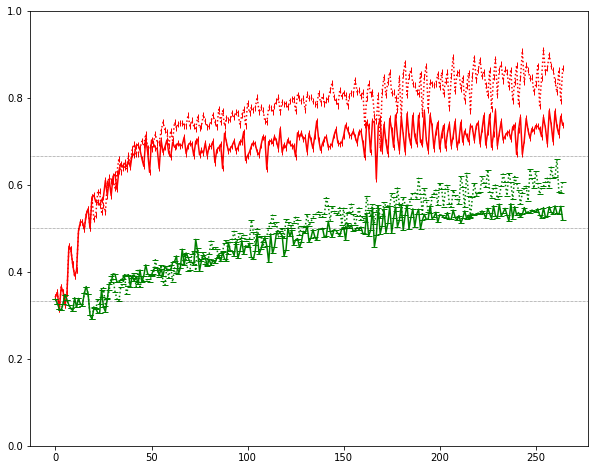

batch  410	 fit accuracy: vert  0.87890625 %, 	 horiz  0.595703125 %	 val accuracy: vert  0.7236328125 %, 	 horiz  0.546875 %
batch  420	 fit accuracy: vert  0.841796875 %, 	 horiz  0.59765625 %	 val accuracy: vert  0.7607421875 %, 	 horiz  0.5595703125 %
batch  430	 fit accuracy: vert  0.8779296875 %, 	 horiz  0.5859375 %	 val accuracy: vert  0.6962890625 %, 	 horiz  0.515625 %
batch  440	 fit accuracy: vert  0.8798828125 %, 	 horiz  0.6044921875 %	 val accuracy: vert  0.71875 %, 	 horiz  0.53515625 %
batch  450	 fit accuracy: vert  0.8505859375 %, 	 horiz  0.640625 %	 val accuracy: vert  0.751953125 %, 	 horiz  0.5693359375 %


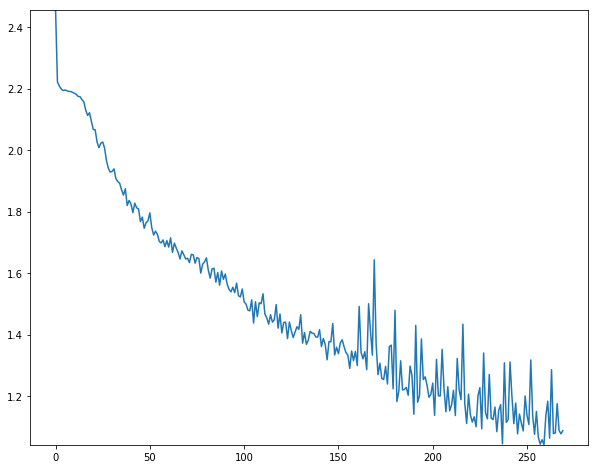

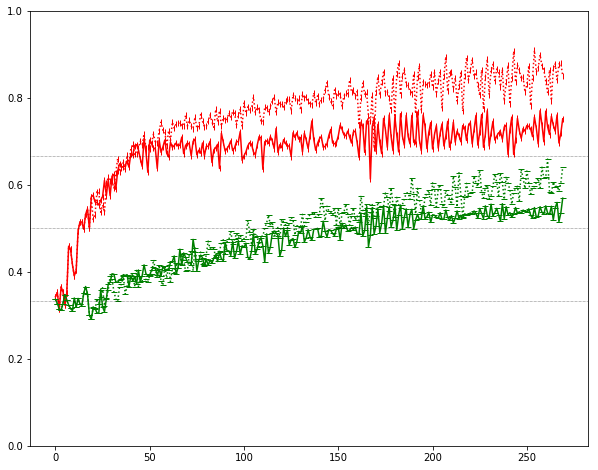

batch  460	 fit accuracy: vert  0.8642578125 %, 	 horiz  0.626953125 %	 val accuracy: vert  0.701171875 %, 	 horiz  0.515625 %
batch  470	 fit accuracy: vert  0.84765625 %, 	 horiz  0.60546875 %	 val accuracy: vert  0.7197265625 %, 	 horiz  0.5380859375 %
batch  480	 fit accuracy: vert  0.8212890625 %, 	 horiz  0.6669921875 %	 val accuracy: vert  0.7421875 %, 	 horiz  0.572265625 %
batch  490	 fit accuracy: vert  0.8935546875 %, 	 horiz  0.6328125 %	 val accuracy: vert  0.732421875 %, 	 horiz  0.5244140625 %
batch  500	 fit accuracy: vert  0.7958984375 %, 	 horiz  0.6025390625 %	 val accuracy: vert  0.6953125 %, 	 horiz  0.5283203125 %


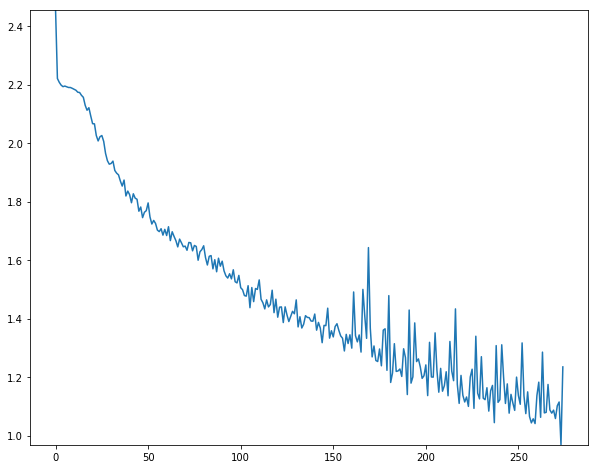

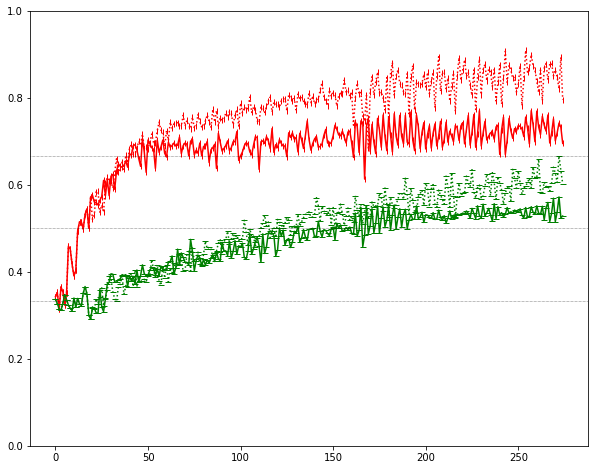

batch  510	 fit accuracy: vert  0.8662109375 %, 	 horiz  0.6416015625 %	 val accuracy: vert  0.7421875 %, 	 horiz  0.580078125 %
batch  520	 fit accuracy: vert  0.8857421875 %, 	 horiz  0.634765625 %	 val accuracy: vert  0.76953125 %, 	 horiz  0.5283203125 %
batch  530	 fit accuracy: vert  0.8017578125 %, 	 horiz  0.619140625 %	 val accuracy: vert  0.6748046875 %, 	 horiz  0.5361328125 %
batch  540	 fit accuracy: vert  0.875 %, 	 horiz  0.599609375 %	 val accuracy: vert  0.744140625 %, 	 horiz  0.568359375 %
batch  550	 fit accuracy: vert  0.8876953125 %, 	 horiz  0.58984375 %	 val accuracy: vert  0.7705078125 %, 	 horiz  0.533203125 %


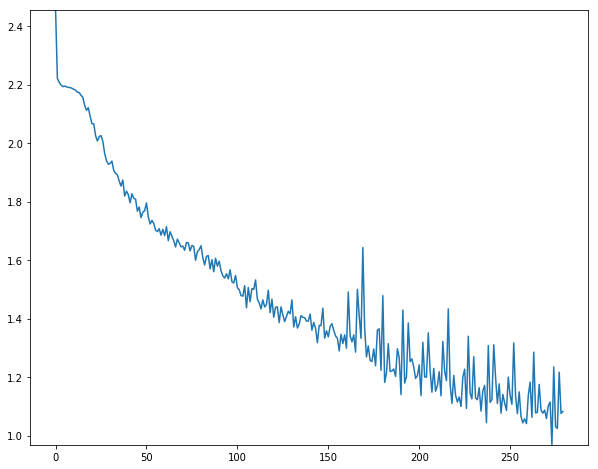

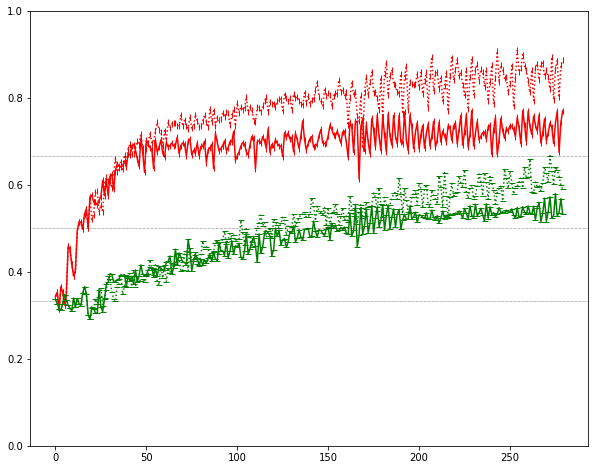

batch  560	 fit accuracy: vert  0.8642578125 %, 	 horiz  0.630859375 %	 val accuracy: vert  0.6650390625 %, 	 horiz  0.5361328125 %
batch  570	 fit accuracy: vert  0.88671875 %, 	 horiz  0.619140625 %	 val accuracy: vert  0.7490234375 %, 	 horiz  0.5673828125 %
batch  580	 fit accuracy: vert  0.875 %, 	 horiz  0.58984375 %	 val accuracy: vert  0.771484375 %, 	 horiz  0.5390625 %
batch  590	 fit accuracy: vert  0.857421875 %, 	 horiz  0.6533203125 %	 val accuracy: vert  0.6572265625 %, 	 horiz  0.5400390625 %


In [77]:

thisscope="v5-try1rb"

print( "continue training - from checkpoint, note that plotting timestep is doubled (after step 162 or so)")

with tf.variable_scope(thisscope):
    for i in range(600):
        if i%10==0:
            print ("batch ",i,end="")
            
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                            ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%", end='' )
            handles[thisscope]["loss_history"].append(loss_value)
            handles[thisscope]["fit_history"].append((a,b))
            vloss_value, vy, vcor_y = sess.run([ handles[thisscope]["val_loss"],
                                              handles[thisscope]["val_y"],
                                              handles[thisscope]["val_correct_y"],
                                            ] )
            va,vb =  (np.mean( np.argmax(vy[0],axis=1) == vcor_y[0] ),np.mean( np.argmax(vy[1],axis=1) == vcor_y[1] ))
            print ("\t val accuracy: vert ", va, "%, \t horiz ",vb , "%" )
            handles[thisscope]["val_history"].append((va,vb))

        if i%50 == 0:
            plt.plot(handles[thisscope]["loss_history"]); 
            plt.ylim(min(handles[thisscope]["loss_history"]), 
                     min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"]))
                    )
            plt.show()
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
            plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
            plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
            plt.ylim(0,1)
            plt.gca().axhline(y=1/3., color='k', linestyle=':',linewidth=0.5)
            plt.gca().axhline(y=1/2., color='k', linestyle=':',linewidth=0.5)
            plt.gca().axhline(y=2/3., color='k', linestyle=':',linewidth=0.5)
            plt.show()

##### save again

In [79]:

save_my_model(thisscope, handles, sess,'./myckpts','2000steps' )

variables saved:
<tf.Variable 'v5-try1rb/my_v2/layer0-D/weights:0' shape=(1, 1, 16, 10) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer0-D/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer3-C/weights:0' shape=(1, 1, 42, 12) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer3-C/bias:0' shape=(12,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer6-B/weights:0' shape=(1, 1, 76, 18) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer6-B/bias:0' shape=(18,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer8/weights:0' shape=(1, 1, 18, 18) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer8/bias:0' shape=(18,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer10/weights:0' shape=(1, 1, 18, 18) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer10/bias:0' shape=(18,) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer12/weights:0' shape=(1, 1, 18, 6) dtype=float32_ref>
<tf.Variable 'v5-try1rb/my_v2/layer12/bias:0' shape=(6,) dtyp

### v5-try2 : identical to try1-rerun but training w/o shuffle from the beginning
    conclusion: not having shuffle does not slow down training (in fact initially training seems to be better)

In [81]:
thisscope="v5-try2"
handles[thisscope] = initialize_training_forfunc_averages_validtn_v2(thisscope, appended_full_model_v5, averages_1000,
                                                                     "datasets1/1000_train.tfrec", "datasets1/1000_valid.tfrec",  
                                                                     optname="b", shuffle_size=0, validate=True)

##### start training

In [ ]:
thisscope="v5-try2"
with tf.variable_scope(thisscope):
    for i in range(400):
        if i%10==0:
            print ("batch ",i,end="")
            
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                            ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%", end='' )
            handles[thisscope]["loss_history"].append(loss_value)
            handles[thisscope]["fit_history"].append((a,b))
            vloss_value, vy, vcor_y = sess.run([ handles[thisscope]["val_loss"],
                                              handles[thisscope]["val_y"],
                                              handles[thisscope]["val_correct_y"],
                                            ] )
            va,vb =  (np.mean( np.argmax(vy[0],axis=1) == vcor_y[0] ),np.mean( np.argmax(vy[1],axis=1) == vcor_y[1] ))
            print ("\t val accuracy: vert ", va, "%, \t horiz ",vb , "%" )
            handles[thisscope]["val_history"].append((va,vb))

        if i%50 == 0:
            plt.plot(handles[thisscope]["loss_history"]); 
            plt.ylim(min(handles[thisscope]["loss_history"]), 
                     min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"]))
                    )
            plt.show()
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
            plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
            plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
            plt.ylim(0,1)
            plt.gca().axhline(y=1/3., color='k', linestyle=':',linewidth=0.5)
            plt.gca().axhline(y=1/2., color='k', linestyle=':',linewidth=0.5)
            plt.gca().axhline(y=2/3., color='k', linestyle=':',linewidth=0.5)
            plt.show()

##### continue training

batch  0	 fit accuracy: vert  0.740234375 %, 	 horiz  0.53125 %	 val accuracy: vert  0.6982421875 %, 	 horiz  0.4619140625 %


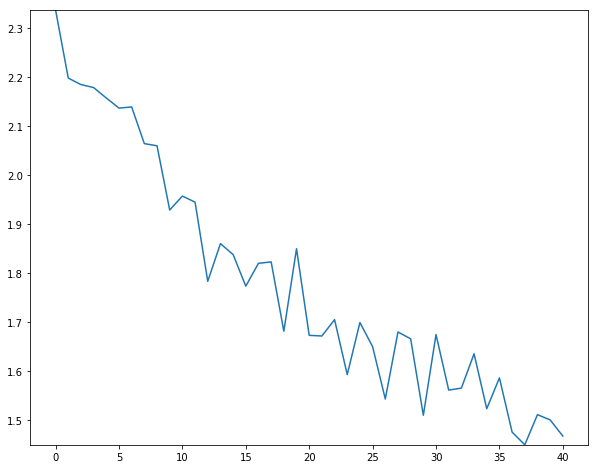

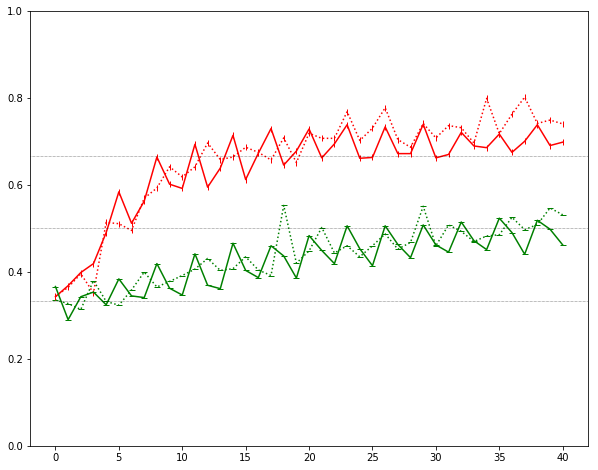

batch  10	 fit accuracy: vert  0.72265625 %, 	 horiz  0.5048828125 %	 val accuracy: vert  0.7392578125 %, 	 horiz  0.5234375 %
batch  20	 fit accuracy: vert  0.7236328125 %, 	 horiz  0.5380859375 %	 val accuracy: vert  0.6953125 %, 	 horiz  0.509765625 %
batch  30	 fit accuracy: vert  0.7529296875 %, 	 horiz  0.544921875 %	 val accuracy: vert  0.69921875 %, 	 horiz  0.4599609375 %
batch  40	 fit accuracy: vert  0.7294921875 %, 	 horiz  0.4873046875 %	 val accuracy: vert  0.7333984375 %, 	 horiz  0.521484375 %
batch  50	 fit accuracy: vert  0.828125 %, 	 horiz  0.51171875 %	 val accuracy: vert  0.703125 %, 	 horiz  0.5009765625 %


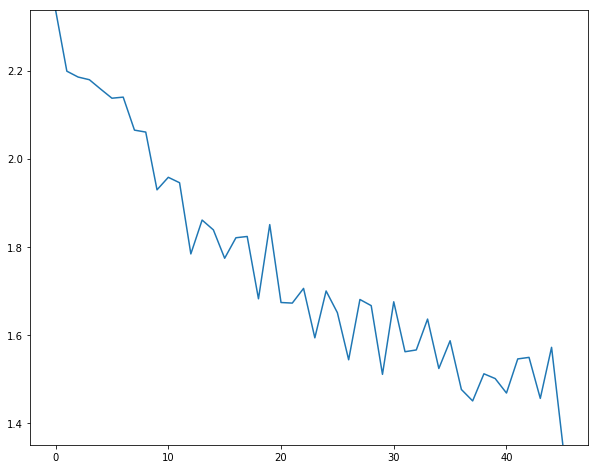

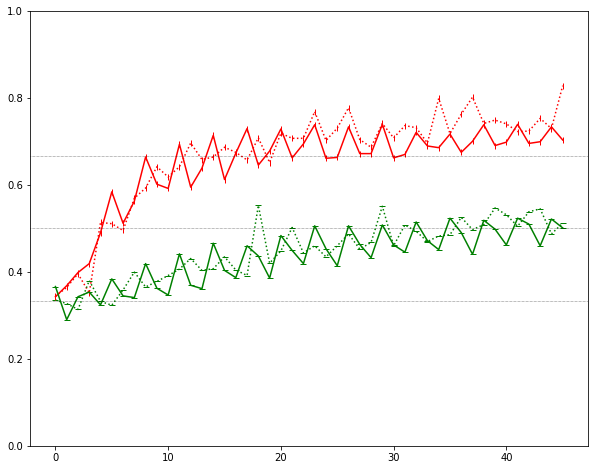

batch  60	 fit accuracy: vert  0.7802734375 %, 	 horiz  0.5166015625 %	 val accuracy: vert  0.689453125 %, 	 horiz  0.4775390625 %
batch  70	 fit accuracy: vert  0.7734375 %, 	 horiz  0.5517578125 %	 val accuracy: vert  0.7353515625 %, 	 horiz  0.51171875 %
batch  80	 fit accuracy: vert  0.8203125 %, 	 horiz  0.4912109375 %	 val accuracy: vert  0.705078125 %, 	 horiz  0.5146484375 %
batch  90	 fit accuracy: vert  0.7998046875 %, 	 horiz  0.544921875 %	 val accuracy: vert  0.68359375 %, 	 horiz  0.46484375 %
batch  100	 fit accuracy: vert  0.771484375 %, 	 horiz  0.5439453125 %	 val accuracy: vert  0.7353515625 %, 	 horiz  0.515625 %


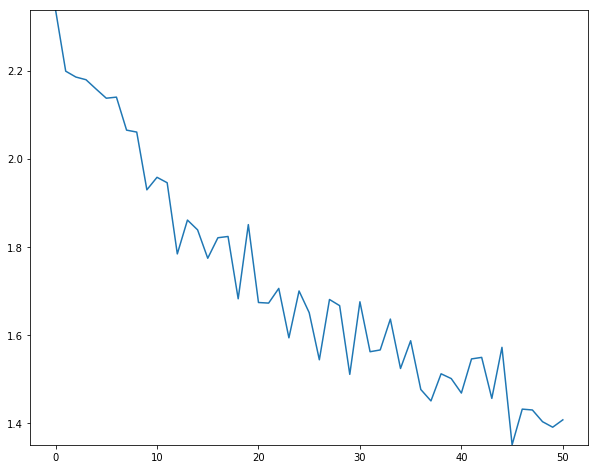

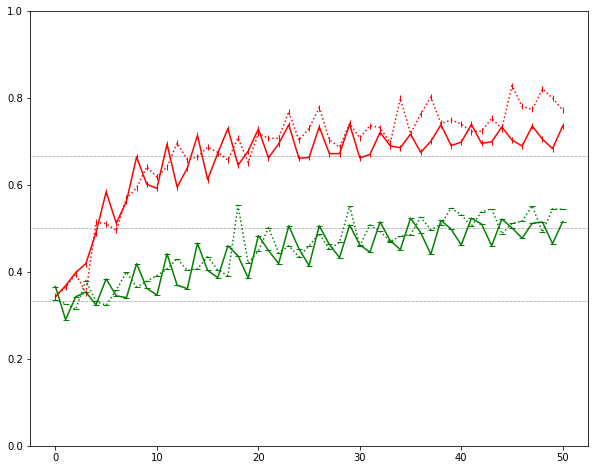

batch  110	 fit accuracy: vert  0.7666015625 %, 	 horiz  0.5400390625 %	 val accuracy: vert  0.7216796875 %, 	 horiz  0.509765625 %
batch  120	 fit accuracy: vert  0.767578125 %, 	 horiz  0.5224609375 %	 val accuracy: vert  0.673828125 %, 	 horiz  0.4697265625 %
batch  130	 fit accuracy: vert  0.744140625 %, 	 horiz  0.5400390625 %	 val accuracy: vert  0.7197265625 %, 	 horiz  0.5234375 %
batch  140	 fit accuracy: vert  0.76171875 %, 	 horiz  0.5634765625 %	 val accuracy: vert  0.7412109375 %, 	 horiz  0.533203125 %
batch  150	 fit accuracy: vert  0.7314453125 %, 	 horiz  0.5185546875 %	 val accuracy: vert  0.6591796875 %, 	 horiz  0.46484375 %


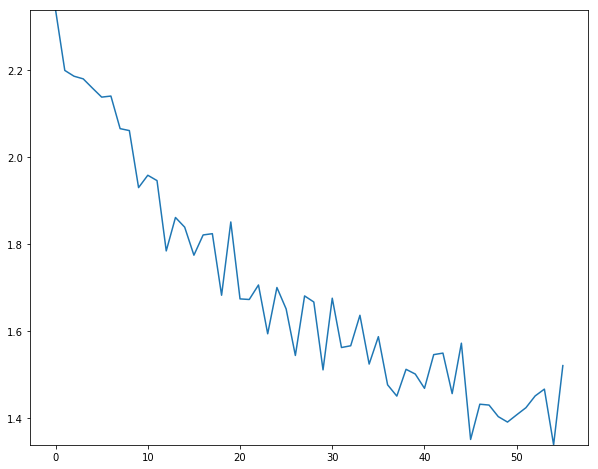

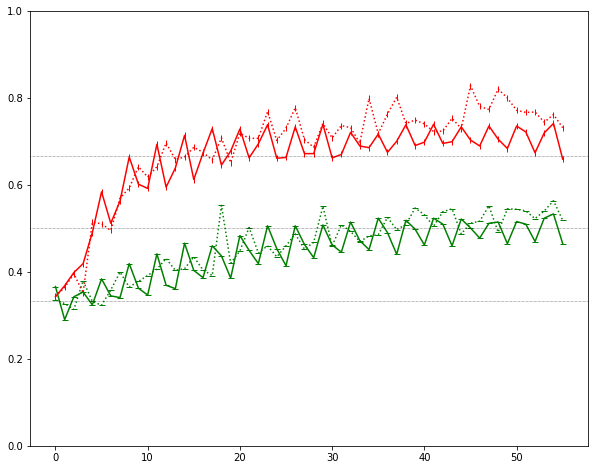

batch  160	 fit accuracy: vert  0.8134765625 %, 	 horiz  0.5419921875 %	 val accuracy: vert  0.7587890625 %, 	 horiz  0.5107421875 %
batch  170	 fit accuracy: vert  0.794921875 %, 	 horiz  0.5478515625 %	 val accuracy: vert  0.7333984375 %, 	 horiz  0.5185546875 %
batch  180	 fit accuracy: vert  0.75390625 %, 	 horiz  0.55859375 %	 val accuracy: vert  0.6884765625 %, 	 horiz  0.4677734375 %
batch  190	 fit accuracy: vert  0.8173828125 %, 	 horiz  0.5048828125 %	 val accuracy: vert  0.7373046875 %, 	 horiz  0.5302734375 %
batch  200	 fit accuracy: vert  0.8017578125 %, 	 horiz  0.5546875 %	 val accuracy: vert  0.736328125 %, 	 horiz  0.515625 %


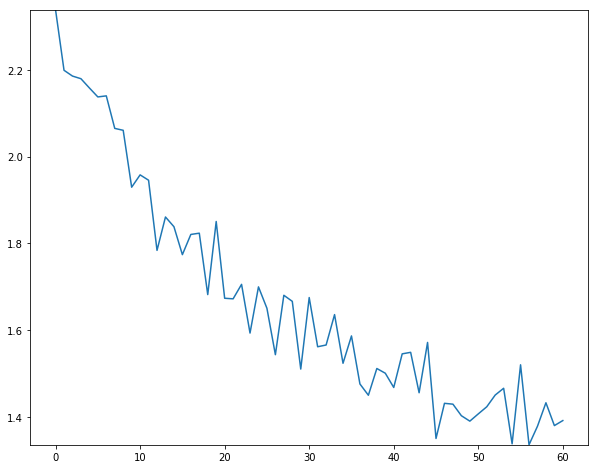

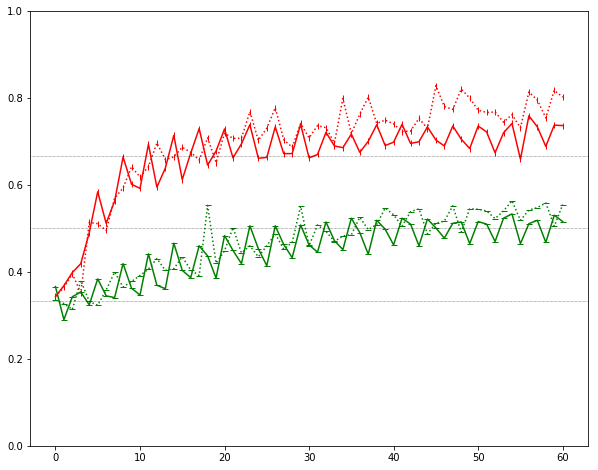

batch  210	 fit accuracy: vert  0.7822265625 %, 	 horiz  0.5419921875 %	 val accuracy: vert  0.6953125 %, 	 horiz  0.4873046875 %
batch  220	 fit accuracy: vert  0.8056640625 %, 	 horiz  0.525390625 %	 val accuracy: vert  0.7392578125 %, 	 horiz  0.515625 %
batch  230	 fit accuracy: vert  0.7998046875 %, 	 horiz  0.5537109375 %	 val accuracy: vert  0.7314453125 %, 	 horiz  0.5107421875 %
batch  240	 fit accuracy: vert  0.779296875 %, 	 horiz  0.53515625 %	 val accuracy: vert  0.6962890625 %, 	 horiz  0.4921875 %
batch  250	 fit accuracy: vert  0.7783203125 %, 	 horiz  0.5625 %	 val accuracy: vert  0.7421875 %, 	 horiz  0.5234375 %


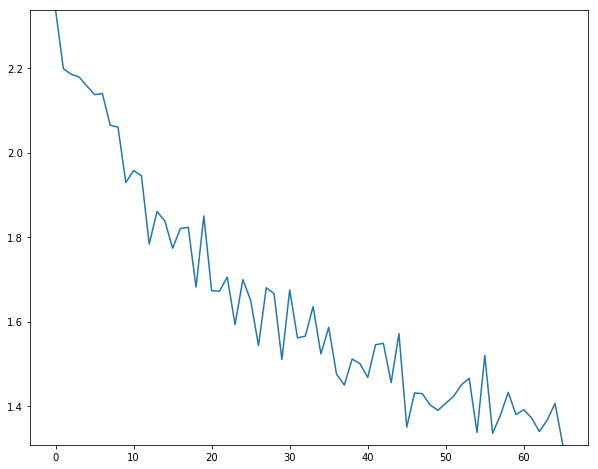

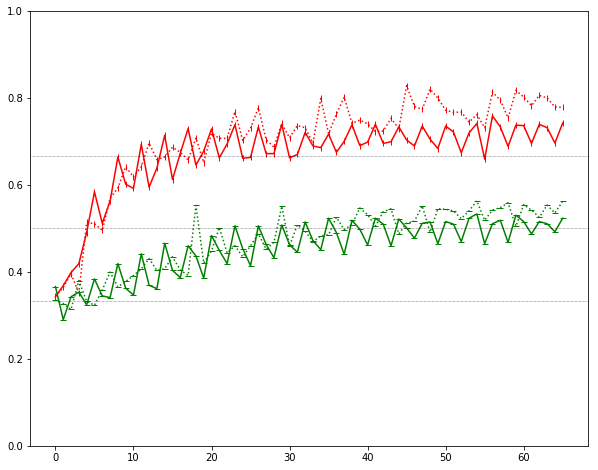

batch  260	 fit accuracy: vert  0.763671875 %, 	 horiz  0.529296875 %	 val accuracy: vert  0.7412109375 %, 	 horiz  0.51171875 %
batch  270	 fit accuracy: vert  0.814453125 %, 	 horiz  0.560546875 %	 val accuracy: vert  0.6845703125 %, 	 horiz  0.4853515625 %
batch  280	 fit accuracy: vert  0.7861328125 %, 	 horiz  0.548828125 %	 val accuracy: vert  0.7275390625 %, 	 horiz  0.5224609375 %
batch  290	 fit accuracy: vert  0.759765625 %, 	 horiz  0.5498046875 %	 val accuracy: vert  0.75390625 %, 	 horiz  0.5224609375 %
batch  300	 fit accuracy: vert  0.8369140625 %, 	 horiz  0.529296875 %	 val accuracy: vert  0.6806640625 %, 	 horiz  0.4970703125 %


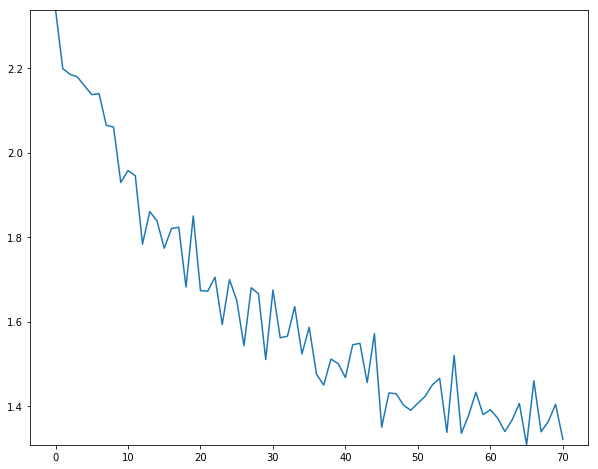

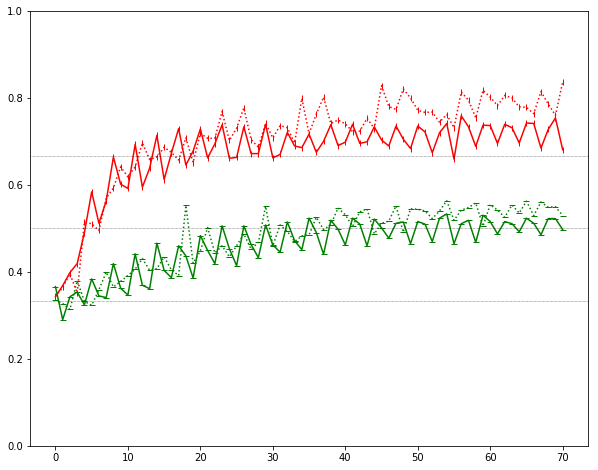

batch  310	 fit accuracy: vert  0.85546875 %, 	 horiz  0.5322265625 %	 val accuracy: vert  0.7314453125 %, 	 horiz  0.5166015625 %
batch  320	 fit accuracy: vert  0.8115234375 %, 	 horiz  0.5751953125 %	 val accuracy: vert  0.7578125 %, 	 horiz  0.5185546875 %
batch  330	 fit accuracy: vert  0.8359375 %, 	 horiz  0.53515625 %	 val accuracy: vert  0.6767578125 %, 	 horiz  0.484375 %
batch  340	 fit accuracy: vert  0.8310546875 %, 	 horiz  0.5712890625 %	 val accuracy: vert  0.724609375 %, 	 horiz  0.529296875 %
batch  350	 fit accuracy: vert  0.787109375 %, 	 horiz  0.5712890625 %	 val accuracy: vert  0.751953125 %, 	 horiz  0.521484375 %


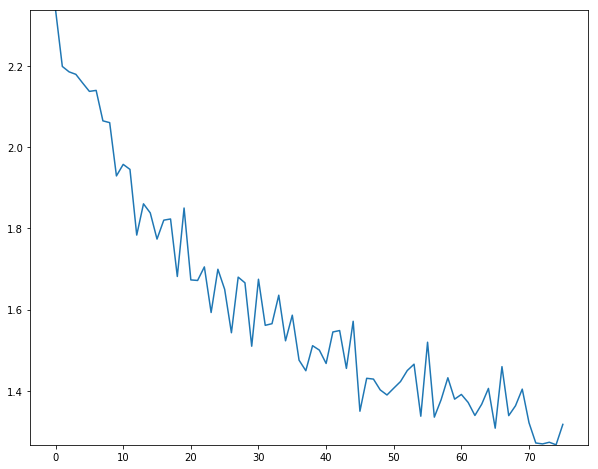

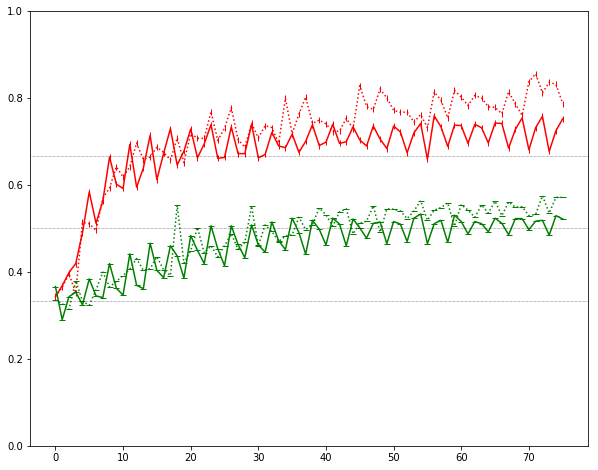

batch  360	 fit accuracy: vert  0.791015625 %, 	 horiz  0.5380859375 %	 val accuracy: vert  0.685546875 %, 	 horiz  0.5048828125 %
batch  370	 fit accuracy: vert  0.77734375 %, 	 horiz  0.556640625 %	 val accuracy: vert  0.736328125 %, 	 horiz  0.529296875 %
batch  380	 fit accuracy: vert  0.7861328125 %, 	 horiz  0.572265625 %	 val accuracy: vert  0.7451171875 %, 	 horiz  0.5107421875 %
batch  390	 fit accuracy: vert  0.796875 %, 	 horiz  0.5732421875 %	 val accuracy: vert  0.6904296875 %, 	 horiz  0.50390625 %


In [83]:
thisscope="v5-try2"
with tf.variable_scope(thisscope):
    for i in range(400):
        if i%10==0:
            print ("batch ",i,end="")
            
        _, loss_value, y, cor_y = sess.run([ handles[thisscope]["train_op"], 
                                             handles[thisscope]["loss"],
                                             handles[thisscope]["y"],
                                             handles[thisscope]["correct_y"],
                                            ] )
        
        if i%10==0:
            a,b =  (np.mean( np.argmax(y[0],axis=1) == cor_y[0] ),np.mean( np.argmax(y[1],axis=1) == cor_y[1] ))
            print ("\t fit accuracy: vert ", a, "%, \t horiz ",b , "%", end='' )
            handles[thisscope]["loss_history"].append(loss_value)
            handles[thisscope]["fit_history"].append((a,b))
            vloss_value, vy, vcor_y = sess.run([ handles[thisscope]["val_loss"],
                                              handles[thisscope]["val_y"],
                                              handles[thisscope]["val_correct_y"],
                                            ] )
            va,vb =  (np.mean( np.argmax(vy[0],axis=1) == vcor_y[0] ),np.mean( np.argmax(vy[1],axis=1) == vcor_y[1] ))
            print ("\t val accuracy: vert ", va, "%, \t horiz ",vb , "%" )
            handles[thisscope]["val_history"].append((va,vb))

        if i%50 == 0:
            plt.plot(handles[thisscope]["loss_history"]); 
            plt.ylim(min(handles[thisscope]["loss_history"]), 
                     min(3*max(handles[thisscope]["loss_history"][-10:]), max(handles[thisscope]["loss_history"]))
                    )
            plt.show()
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,0], 'r|:')
            plt.plot(np.array(handles[thisscope]["fit_history"])[:,1], 'g_:');
            plt.plot(np.array(handles[thisscope]["val_history"])[:,0], 'r|-')
            plt.plot(np.array(handles[thisscope]["val_history"])[:,1], 'g_-'); 
            plt.ylim(0,1)
            plt.gca().axhline(y=1/3., color='k', linestyle=':',linewidth=0.5)
            plt.gca().axhline(y=1/2., color='k', linestyle=':',linewidth=0.5)
            plt.gca().axhline(y=2/3., color='k', linestyle=':',linewidth=0.5)
            plt.show()

##### statistics:

In [268]:
print("success rate recognizing vertical tail position :")
dfvert = ( df.groupby(['vert','horiz'])[['success_vert']].mean() ).reset_index().pivot(index='vert',
                                                                                       columns='horiz',
                                                                                       values='success_vert')
dfvert. style.background_gradient(cmap='RdYlGn',low=2,high=0.4, axis=1)

success rate recognizing vertical tail position :


horiz,left,right,straight
vert,,,
down,0.788462,0.65812,0.747573
level,0.71134,0.790476,0.776978
up,0.808,0.863248,0.957265


In [269]:
print("success rate recognizing horizontal tail position :")
(df.groupby(['vert','horiz'])[['success_horiz']].mean()
    ).reset_index().pivot(index='vert',
                          columns='horiz',
                          values='success_horiz'). style.background_gradient(cmap='RdYlGn',low=1,high=0.35,axis=0)

success rate recognizing horizontal tail position :


horiz,left,right,straight
vert,,,
down,0.903846,0.846154,0.631068
level,0.762887,0.72381,0.863309
up,0.776,0.777778,0.905983
